In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob
from netCDF4 import Dataset
import json
import xarray as xr
%matplotlib inline

In [6]:
# era_AREA = area_grid_cell(lat, 0.375, 0.375)

In [7]:
#nc_path   = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_coordinates/msthesis/'
nc_path  = '//home/hanna/lagrings/satelite_coordinates/msthesis/'
save_dir = '/home/hanna/images_simple_statsmodels/'
#save_dir = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_coordinates/msthesis/'
nc_files  = glob.glob(nc_path + '*.nc')

In [8]:
nc_files

['//home/hanna/lagrings/satelite_coordinates/msthesis/target_grid_slice.nc',
 '//home/hanna/lagrings/satelite_coordinates/msthesis/input_grid_cloud_mask.nc',
 '//home/hanna/lagrings/satelite_coordinates/msthesis/cloud_mask_after_selname.nc',
 '//home/hanna/lagrings/satelite_coordinates/msthesis/cloud_mask.nc']

In [9]:
changed_both = nc_files[-1]

In [10]:
data = xr.open_dataset(changed_both)

In [13]:
cloud_mask = data.cloudMask.values.reshape(-1)

In [14]:
def add(a, b):
    return np.abs(a) + np.abs(b)

def subtract(a, b):
    return np.abs(a) - np.abs(b)

In [15]:
#data = data.drop('latitude')
#data = data.drop('longitude')

In [16]:
data

<xarray.Dataset>
Dimensions:    (lat: 3712, lon: 3712)
Coordinates:
    latitude   (lat, lon) float32 ...
    longitude  (lat, lon) float32 ...
Dimensions without coordinates: lat, lon
Data variables:
    cloudMask  (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    CDI:                             Climate Data Interface version 1.8.0 (ht...
    Conventions:                     CF-1.0
    history:                         Sat Sep 28 13:25:35 2019: ncatted -a coo...
    source:                          /data/products/1338648/MSG4-SEVI-MSGCLMK...
    institution:                     EUMETSAT
    creator_name:                    EUMETSAT
    creator_url:                     http://archive.eumetsat.int
    creator_email:                   archive@eumetsat.int
    license:                         CopyRight EUMETSAT 2008
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    title:                           EUMETSAT-ARCHIVE-CLOUD-MASK-NetCDF
    su

In [37]:
#data.cloudMask.plot()

In [17]:
def area_grid_cell(c_lat, d_lat, d_lon):
        """
        c_lat : float
            Centre point longitude, latitude in degrees

        d_lat, d_lon : float
            delta lat lon in degrees

        Returns : area in km^2

        cdo : If the grid cell area have to be computed it is scaled with the earth radius to square meters.
        """
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)


In [18]:
def compute_dDegrees(lat, lon):
    """
    lat, lon shape is (3712, 3712).
    """  
    #assert lat.shape == lon.shape == (3712, 3712), 'Wrong shape of lat and lon expected (3712, 3712), got lat.shape {} and lon.shape {}'.format(lat.shape, lon.shape)
    d_phi      = np.nan*np.zeros(np.shape(lat))
    d_theta    = np.nan*np.zeros(np.shape(lat))
    cell_areas = np.nan*np.zeros(np.shape(lat))
    
    for i in range(1, len(lat)-1):
        for j in range(1, len(lat)-1):
            #left_half_dist     = subtract(lon[i, j],  lon[i, j+1])
            #right_half_dist    = subtract(lon[i, j-1], lon[i, j])                
            #print("left_half_dist {}, right _half_dist {}".format(left_half_dist, right_half_dist))
            dlon               = (subtract(lon[i, j-1],  lon[i, j+1]))/4
            d_phi[i][j]        = dlon

            #upper_half_dist    = subtract(lat[i+1, j], lat[i, j])
            #lower_half_dist    = subtract(lat[i, j], lat[i-1, j])
            #print("upper_half_dist {}, lower_half_dist {}".format(upper_half_dist, lower_half_dist))
            dlat               = subtract(lat[i+1, j], lat[i-1, j])/4
            d_theta[i][j]      = dlat
                
            cell_areas[i][j] = area_grid_cell(lat[i, j], dlat, dlon)       
            
    return d_phi, d_theta, cell_areas

In [19]:
data.longitude.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [20]:
lat_array = data.latitude.values
lon_array = data.longitude.values

In [16]:
d_phi, d_theta, cell_areas = compute_dDegrees(lat = data.latitude.values, lon = data.longitude.values)

In [21]:
glob.glob(save_dir + '*json')

['/home/hanna/images_simple_statsmodels/changes_lat_lon_cell-area.json']

In [22]:
def read_dlon_dlat(filename):
    nc_files = glob.glob(save_dir+'*cell*.json')
    with open(nc_files[-1]) as f:
        d =  json.load(f)
    d_phi      = d['dphi'] 
    d_theta    = d['dtheta'] 
    cell_areas = d['cell_area']
    lat_array = d['lat'] 
    lon_array = d['lon']
    #save_dict_to_json(d, "changes_lat_lon_cell-area.json", save_dir = save_dir)
    return d_phi, d_theta, cell_areas, lat_array, lon_array

In [23]:
d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(data)

# Lagre d_phi og d_theta og cell areas i json fil.

In [21]:
def save_dict_to_json(di, filename, save_dir = ''):
    with open(save_dir + filename, 'w') as f:
            json.dump(di, f)

In [22]:
def save_dlon_dlat():
    d = {}
    d['dphi'] = d_phi.reshape(-1).tolist()
    d['dtheta'] = d_theta.reshape(-1).tolist()
    d['cell_area'] = cell_areas.reshape(-1).tolist()
    d['lat'] = lat_array.reshape(-1).tolist()
    d['lon'] = lon_array.reshape(-1).tolist()
    save_dict_to_json(d, "changes_lat_lon_cell-area.json", save_dir = save_dir)
    return

In [23]:
save_dlon_dlat()

In [25]:

"""
ax = sns.heatmap(np.abs(d_phi), vmax = 0.04)

ax.tick_params(left=False, bottom=False)
ax.set_xticklabels([' '])
ax.set_yticklabels([' '])
ax.set_title('Resolution Longitude')

plt.savefig(save_dir + "resolution_lon.png")
"""

'\nax = sns.heatmap(np.abs(d_phi), vmax = 0.04)\n\nax.tick_params(left=False, bottom=False)\nax.set_xticklabels([\' \'])\nax.set_yticklabels([\' \'])\nax.set_title(\'Resolution Longitude\')\n\nplt.savefig(save_dir + "resolution_lon.png")\n'

In [ ]:
ax2 = sns.heatmap(np.abs(d_theta), vmax = 0.04)
ax2.set_title('Resolution Latitude') 
ax2.set_xticklabels([' '])
ax2.set_yticklabels([' '])
ax2.tick_params(left=False, bottom=False)

plt.savefig(save_dir + "resolution_lat.png")

In [ ]:
ax2 = sns.heatmap(data.cloudMask.values)
ax2.set_title('Cloud Mask')
ax2.set_xticklabels([' '])
ax2.set_yticklabels([' '])
ax2.tick_params(left=False, bottom=False)

plt.savefig(save_dir + "cloud_mask.png")

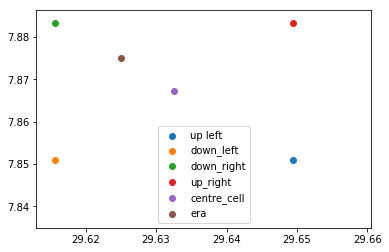

In [45]:
for index in idx_lower_right_corner:
    """ plot Index """
    plt.scatter(cmk_up[index],   cmk_left[index], label = 'up left' )
    plt.scatter(cmk_down[index], cmk_left[index] , label = 'down_left')
    plt.scatter(cmk_down[index], cmk_right[index], label = 'down_right' )
    plt.scatter(cmk_up[index],   cmk_right[index],  label = 'up_right' )
    plt.scatter(c_lat[index],    c_lon[index],  label = 'centre_cell')
    """ plot Scatter era cell """
    plt.scatter(era_down,        era_right, label = 'era') 
    #plt.scatter(era_down,        era_left)
    #plt.scatter(era_up,          era_right)
    #plt.scatter(era_up,          era_left)
plt.legend()
plt.savefig(save_dir+'corner_problem2.png')

In [26]:
def compute_area_one_cell(lat = 60, lon = -15, c_lat = None, 
                          c_lon = None, d_theta = None, d_phi = None, cloud_mask_array = None, era_step = 0.75):
    
    assert c_lon.shape == c_lat.shape == d_theta.shape == d_phi.shape == cloud_mask_array.shape, "c_lon.shape {},  c_lat.shape {},  d_theta.shape {}, d_phi.shape {} cloud_mask_array.shape {}".format(c_lon.shape,  c_lat.shape,  d_theta.shape, d_phi.shape, cloud_mask_array.shape) 
    
    era_AREA = area_grid_cell(lat, era_step, era_step)
    print("lat = {}, lon ={} era_AREA {}".format(era_AREA, lat, lon))

    # Make this a loop over lat_lons?
    lat_bondaries = np.array([[lon],
                              [lat]])

    BOUND =  np.array([[-era_step/2, era_step/2],
                       [-era_step/2, era_step/2]])

    ranges = lat_bondaries + BOUND

    #lon_range = ranges[0, :]
    #lat_range = ranges[1, :]
    #min_lon, max_lon = lon_range
    #min_lat, max_lat = lat_range

    era_up    = ranges[1, 1]
    era_down  = ranges[1, 0]
    era_left  = ranges[0, 0]
    era_right = ranges[0, 1]

    # to ensure correct sign
    cmk_left  = c_lon - np.abs(d_phi)   #- era_right
    cmk_right = c_lon + np.abs(d_phi)   #- era_left

    # TODO : Sjekk d theta og lignende.
    cmk_up    = c_lat + np.abs(d_theta) #- era_down
    cmk_down  = c_lat - np.abs(d_theta) #- era_up

    idx_left_boundary  = np.intersect1d(np.argwhere(cmk_right > era_left),  np.argwhere(cmk_left < era_left) )
    idx_right_boundary = np.intersect1d(np.argwhere(cmk_right > era_right), np.argwhere(cmk_left < era_right) )
    idx_up_boundary    = np.intersect1d(np.argwhere(cmk_up > era_up), np.argwhere(cmk_down < era_up) )
    idx_down_boundary  = np.intersect1d(np.argwhere(cmk_up > era_down), np.argwhere(cmk_down < era_down) )
    
    idx_lower_right_corner = np.intersect1d(idx_down_boundary, idx_right_boundary)
    idx_lower_left_corner  = np.intersect1d(idx_down_boundary, idx_left_boundary)
    idx_upper_left_corner  = np.intersect1d(idx_up_boundary, idx_left_boundary)
    idx_upper_right_corner = np.intersect1d(idx_up_boundary, idx_right_boundary)

    not_1 = np.intersect1d(idx_left_boundary, idx_right_boundary)
    not_2 = np.intersect1d(idx_up_boundary, idx_down_boundary)
    
    corner_idx         = np.concatenate([idx_lower_right_corner, idx_lower_left_corner,
                                         idx_upper_left_corner, idx_upper_right_corner,
                                        not_1, not_2]) # corner idx
  
    #assert len(corner_idx) == 4, "Not correct number of corners, nbr = {}.".format(len(corner_idx))
    
    # TODO add new centre corners. And calculate  
    llc_dlat = subtract(cmk_up[idx_lower_left_corner], era_down)/2
    llc_dlon = subtract(era_left, cmk_right[idx_lower_left_corner])/2
    llc_lat  = era_down + llc_dlat
    f = area_grid_cell(llc_lat, llc_dlat, llc_dlon)
    #print("area lower left area {}".format(f/era_AREA))
    
    lrc_dlat = subtract(cmk_up[idx_lower_right_corner], era_down)/2
    lrc_dlon = subtract(cmk_left[idx_lower_right_corner], era_right)/2
    lrc_lat  = era_down + lrc_dlat
    h = area_grid_cell(lrc_lat, lrc_dlat, lrc_dlon)
    #print("area lower right area {}".format(h/era_AREA))
    
    ulc_dlat = subtract(era_up, cmk_down[idx_upper_left_corner])/2
    ulc_dlon = subtract(era_left, cmk_right[idx_upper_left_corner])/2
    ulc_lat = era_up - ulc_dlat
    i = area_grid_cell(ulc_lat, ulc_dlat, ulc_dlon)
    #print("area upper left area {}".format(i/era_AREA))
    
    urc_dlat = subtract(era_up, cmk_down[idx_upper_right_corner])/2
    urc_dlon = subtract(cmk_left[idx_upper_right_corner], era_right)/2
    urc_lat  = era_up - ulc_dlat
    j = area_grid_cell(urc_lat, urc_dlat, urc_dlon)
    #print("area upper right area {}".format(j/era_AREA))
    
    #print("SUM corners {}".format((i+j+h+f)/era_AREA))

    #if len(corner_idx) == 0:
    #    raise ValueError('No corners found, something is wrong ... ')
    
    #max_lon, min_lon = np.max(c_lon[corner_idx]), np.min(c_lon[corner_idx])
    #max_lat, min_lat = np.max(c_lat[corner_idx]), np.min(c_lat[corner_idx])

    # removes corners
    for idx in corner_idx:
        idx_down_boundary = idx_down_boundary[idx_down_boundary != idx]
        idx_up_boundary = idx_up_boundary[idx_up_boundary != idx]
        idx_left_boundary = idx_left_boundary[idx_left_boundary != idx]
        idx_right_boundary = idx_right_boundary[idx_right_boundary != idx]
        
    
    # subsection left boundary OLD
    low_bound = np.argwhere(cmk_down[idx_left_boundary] < era_up  )
    up_bound  = np.argwhere(cmk_up[idx_left_boundary]   > era_down )
    sub_section_left = np.intersect1d(low_bound, up_bound)

    # subsection right boundary
    low_bound = np.argwhere( cmk_down[idx_right_boundary] < era_up )
    up_bound  = np.argwhere( cmk_up[idx_right_boundary] > era_down)
    sub_section_right = np.intersect1d(low_bound, up_bound)

    # Subsection Down Boundary
    one = np.argwhere(cmk_left[idx_down_boundary]  > era_left)
    two = np.argwhere(cmk_right[idx_down_boundary] < era_right)
    sub_section_down = np.intersect1d(one, two)

    # subsection up boundary
    one = np.argwhere( cmk_left[idx_up_boundary]  > era_left)
    two = np.argwhere( cmk_right[idx_up_boundary] < era_right)
    sub_section_up = np.intersect1d(one, two)
    
    #plt.scatter(cmk_left[corner_idx], cmk_up[corner_idx],        marker = 'v')
    #plt.scatter(cmk_left[idx_left_boundary][sub_section_left],   cmk_up[idx_left_boundary][sub_section_left])
    #plt.scatter(cmk_left[idx_right_boundary][sub_section_right], cmk_up[idx_right_boundary][sub_section_right])
    #plt.scatter(cmk_left[idx_up_boundary][sub_section_up],       cmk_up[idx_up_boundary][sub_section_up])
    #plt.scatter(cmk_left[idx_down_boundary][sub_section_down],   cmk_up[idx_down_boundary][sub_section_down])
    #plt.show()
    
    # test that these are empty
    t1 = np.intersect1d(idx_down_boundary, idx_up_boundary)
    t2 = np.intersect1d(idx_right_boundary, idx_left_boundary)
    #assert len(t1) == len(t2) == 0, "intercept up down  {}, intersect left right {}.".format(t1, t2)
    
    if len(t1) != 0:
        print("Problem up, down lat {} lon {}".format(lat, lon))
    
        
    if len(t2) != 0:
        print(" problem left right lat {} lon {}".format(lat, lon))
    # Calculate Boundaries

    # AREA left boundary
    dlon_lf = subtract(cmk_right[idx_left_boundary][sub_section_left], era_left)/2 
    dlat_lf = d_theta[idx_left_boundary][sub_section_left]
    lat_lf  = c_lat[idx_left_boundary][sub_section_left]
    #lon_lf  = c_lon[idx_left_boundary][sub_section_left]

    a = np.sum(area_grid_cell(lat_lf, dlat_lf, np.abs(dlon_lf)))

    fraction_left = (cloud_mask_array[idx_left_boundary][sub_section_left]*area_grid_cell(lat_lf,
                                                                                          dlat_lf,
                                                                                          dlon_lf)/era_AREA).sum()
    # AREA right boundary
    dlon_rb = subtract(era_right, cmk_left[idx_right_boundary][sub_section_right])/2
    dlat_rb = d_theta[idx_right_boundary][sub_section_right]
    lat_rb  = c_lat[idx_right_boundary][sub_section_right]
    #lon_rb = c_lon[idx_right_boundary][sub_section_right]

    b = np.sum(area_grid_cell(lat_rb, dlat_rb, np.abs(dlon_rb)))

    fraction_right = (cloud_mask_array[idx_right_boundary][sub_section_right]*area_grid_cell(lat_rb,
                                                                                             dlat_rb,
                                                                                             dlon_rb)/era_AREA).sum()

    # AREA down boundary
    dlat_down = subtract(era_down, cmk_up[idx_down_boundary][sub_section_down])/2
    lat_down = era_down + dlat_down
    dlon_down = d_phi[idx_down_boundary][sub_section_down]
    #lon_down =  c_lon[idx_down_boundary][sub_section_down]

    c = np.sum(area_grid_cell(lat_down, dlat_down, dlon_down))

    fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down,
                                                                                          dlat_down,
                                                                                          dlon_down)/era_AREA).sum()
    # AREA up
    dlat_up = subtract(era_up, cmk_down[idx_up_boundary][sub_section_up])/2
    lat_up = era_up - dlat_up
    #lon_up = c_lon[idx_up_boundary][sub_section_up]
    dlon_up = d_phi[idx_up_boundary][sub_section_up]

    d = np.sum(area_grid_cell(lat_up, dlat_up, np.abs(dlon_up)))

    fraction_up = (cloud_mask_array[idx_up_boundary][sub_section_up]*area_grid_cell(lat_up,
                                                                 dlat_up,
                                                                 dlon_up)/era_AREA).sum()
    # Index centres. Can safly assume centre cells are correct.
    idx_centre_one = np.intersect1d(np.argwhere(cmk_left  > era_left),
                                    np.argwhere(cmk_right < era_right))


    idx_centre_two = np.intersect1d(np.argwhere(cmk_up   < era_up),
                                    np.argwhere(cmk_down >  era_down))

    idx_centre_cells = np.intersect1d( idx_centre_one, idx_centre_two )
    lat_centre_cells = c_lat[idx_centre_cells]
    dlat_centre      = d_theta[idx_centre_cells]
    dlon_centre      = d_phi[idx_centre_cells]
    
    #plt.scatter(cmk_left[idx_centre_cells], cmk_up[idx_centre_cells])
    #plt.scatter([lon+.375, lon-.375, lon+.375, lon-.375,], [lat+.375, lat+.375, lat-.375,lat-.375])
    #plt.show()
    
    fraction_centre  = (cloud_mask_array[idx_centre_cells]*area_grid_cell(lat_centre_cells,
                                                                 dlat_centre,
                                                                 dlon_centre)/era_AREA).sum()
    #print("era_AREA {}".format(era_AREA))
    #print("Sum up {}".format(area_grid_cell(lat_up, dlat_up, dlon_up).sum()/era_AREA))
    #print("Sum down {}".format(area_grid_cell(lat_down, dlat_down, dlon_down).sum()/era_AREA))
    #print("Sum centre {}".format(area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() /era_AREA))
    #print("Sum left {}".format(area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum()/era_AREA))
    #print("Sum right {}".format(area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum()/era_AREA))
    
    Test_weight = (area_grid_cell(lat_up, dlat_up, dlon_up).sum() +
                   area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() +
                   area_grid_cell(lat_down, dlat_down, dlon_down).sum() +
                   area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum() +
                   area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum() ) /era_AREA# + (i+j+h+f)/era_AREA
    
    print("SUM weight {}".format(Test_weight[0]))
    return Test_weight[0]


In [46]:
#lats = 
#lons = np.arange(-15, 30, 0.75)

def store_area_index_info(lats = np.arange(30, 56, 0.75), lons = np.arange(-15, 30, 0.75), 
                          c_lat = None, c_lon = None, d_theta = None, d_phi = None, cloud_mask_array = None, 
                          write_fil = False, era_step = 0.75):
    
    assert c_lon.shape == c_lat.shape == d_theta.shape == d_phi.shape == cloud_mask_array.shape, " c_lon.shape {},  c_lat.shape {},  d_theta.shape {}, d_phi.shape {} cloud_mask_array.shape {}".format(c_lon.shape,  c_lat.shape,  d_theta.shape, d_phi.shape, cloud_mask_array.shape) 
    hh=[]
    data = {}
    counter = 0
    for lat in lats:
        data[str(lat)] = {}
        counter+=1
        for lon in lons:
            data[str(lat)][str(lon)] = {}
            era_AREA = area_grid_cell(lat, era_step/2, era_step/2)
            print("lat = {}, lon = {}".format(lat, lon))
            era_up    = lat + era_step/2
            era_down  = lat - era_step/2
            era_left  = lon - era_step/2
            era_right = lon + era_step/2

            # to ensure correct sign
            cmk_left  = c_lon - np.abs(d_phi)   #- era_right
            cmk_right = c_lon + np.abs(d_phi)   #- era_left

            # TODO : Sjekk d theta og lignende.
            cmk_up    = c_lat + np.abs(d_theta) #- era_down
            cmk_down  = c_lat - np.abs(d_theta) #- era_up
            
            data[str(lat)][str(lon)]['centre'] = {}
            data[str(lat)][str(lon)]['down'] = {}
            data[str(lat)][str(lon)]['up'] = {}
            data[str(lat)][str(lon)]['right'] = {}
            data[str(lat)][str(lon)]['left'] = {}
            data[str(lat)][str(lon)]['corner'] = {}
            
            idx_left_boundary  = np.intersect1d(np.argwhere(cmk_right > era_left),  np.argwhere(cmk_left < era_left) )
            idx_right_boundary = np.intersect1d(np.argwhere(cmk_right > era_right), np.argwhere(cmk_left < era_right) )
            idx_up_boundary    = np.intersect1d(np.argwhere(cmk_up > era_up),       np.argwhere(cmk_down < era_up) )
            idx_down_boundary  = np.intersect1d(np.argwhere(cmk_up > era_down),     np.argwhere(cmk_down < era_down) )

            data[str(lat)][str(lon)]['down']['index']  = idx_down_boundary.tolist()
            data[str(lat)][str(lon)]['up']['index']    = idx_up_boundary.tolist()
            data[str(lat)][str(lon)]['left']['index']  = idx_left_boundary.tolist()
            data[str(lat)][str(lon)]['right']['index'] = idx_right_boundary.tolist()
            
            idx_lower_right_corner = np.intersect1d(idx_down_boundary, idx_right_boundary)
            idx_lower_left_corner  = np.intersect1d(idx_down_boundary, idx_left_boundary)
            idx_upper_left_corner  = np.intersect1d(idx_up_boundary, idx_left_boundary)
            idx_upper_right_corner = np.intersect1d(idx_up_boundary, idx_right_boundary)
            
            corner_idx         = np.concatenate([idx_lower_right_corner, idx_lower_left_corner,
                                                 idx_upper_left_corner, idx_upper_right_corner]) # corner idx
            data[str(lat)][str(lon)]['corner']['index'] = corner_idx.tolist()
            #assert len(corner_idx) == 4, "Not correct number of corners, nbr = {}.".format(len(corner_idx))
                
            # TODO add new centre corners. And calculate  
            llc_dlat = subtract(cmk_up[idx_lower_left_corner], era_down)/2
            llc_dlon = subtract(era_left, cmk_right[idx_lower_left_corner])/2
            llc_lat  = era_down + llc_dlat
            
            llc_area = area_grid_cell(llc_lat, llc_dlat, llc_dlon)
            #print("area lower left area {}".format(f/era_AREA))

            lrc_dlat = subtract(cmk_up[idx_lower_right_corner], era_down)/2
            lrc_dlon = subtract(cmk_left[idx_lower_right_corner], era_right)/2
            
            lrc_lat  = era_down + lrc_dlat
            lrc_area = area_grid_cell(lrc_lat, lrc_dlat, lrc_dlon)
            #print("area lower right area {}".format(h/era_AREA))

            ulc_dlat = subtract(era_up, cmk_down[idx_upper_left_corner])/2
            ulc_dlon = subtract(era_left, cmk_right[idx_upper_left_corner])/2
            ulc_lat = era_up - ulc_dlat
            ulc_area = area_grid_cell(ulc_lat, ulc_dlat, ulc_dlon)
            #print("area upper left area {}".format(i/era_AREA))

            urc_dlat = subtract(era_up, cmk_down[idx_upper_right_corner])/2
            urc_dlon = subtract(cmk_left[idx_upper_right_corner], era_right)/2
            urc_lat  = era_up - ulc_dlat
            urc_area = area_grid_cell(urc_lat, urc_dlat, urc_dlon)
            #print("area upper right area {}".format(j/era_AREA))
            #print("SUM corners {}".format((i+j+h+f)/era_AREA))

            corner_areas = np.array([lrc_area, llc_area, ulc_area, urc_area])
            data[str(lat)][str(lon)]['corner']['area'] = corner_areas.tolist()
                        
            #assert len(corner_idx) == 4, "Expected four corners, got {}".format(len(corner_idx))
                           
            #max_lon, min_lon = np.max(c_lon[corner_idx]), np.min(c_lon[corner_idx])
            #max_lat, min_lat = np.max(c_lat[corner_idx]), np.min(c_lat[corner_idx])



            # removes corners
            for idx in corner_idx:
                idx_down_boundary = idx_down_boundary[idx_down_boundary != idx]
                idx_up_boundary = idx_up_boundary[idx_up_boundary != idx]
                idx_left_boundary = idx_left_boundary[idx_left_boundary != idx]
                idx_right_boundary = idx_right_boundary[idx_right_boundary != idx]

            # subsection left boundary OLD
            low_bound = np.argwhere(cmk_down[idx_left_boundary] < era_up  )
            up_bound  = np.argwhere(cmk_up[idx_left_boundary]   > era_down )
            sub_section_left = np.intersect1d(low_bound, up_bound)
            
            data[str(lat)][str(lon)]['left']['index_subset'] = sub_section_left.tolist()
            
            # subsection right boundary
            low_bound = np.argwhere( cmk_down[idx_right_boundary] < era_up )
            up_bound  = np.argwhere( cmk_up[idx_right_boundary] > era_down)
            sub_section_right = np.intersect1d(low_bound, up_bound)
            data[str(lat)][str(lon)]['right']['index_right'] = sub_section_right.tolist()
            
            # Subsection Down Boundary
            one = np.argwhere(cmk_left[idx_down_boundary]  > era_left)
            two = np.argwhere(cmk_right[idx_down_boundary] < era_right)
            sub_section_down = np.intersect1d(one, two)
            data[str(lat)][str(lon)]['down']['index_subset'] = sub_section_down.tolist()

            # subsection up boundary
            one = np.argwhere( cmk_left[idx_up_boundary]  > era_left)
            two = np.argwhere( cmk_right[idx_up_boundary] < era_right)
            sub_section_up = np.intersect1d(one, two)
            data[str(lat)][str(lon)]['up']['index_subset'] = sub_section_up.tolist()
            #plt.scatter(cmk_left[corner_idx], cmk_up[corner_idx],        marker = 'v')
            #plt.scatter(cmk_left[idx_left_boundary][sub_section_left],   cmk_up[idx_left_boundary][sub_section_left])
            #plt.scatter(cmk_left[idx_right_boundary][sub_section_right], cmk_up[idx_right_boundary][sub_section_right])
            #plt.scatter(cmk_left[idx_up_boundary][sub_section_up],       cmk_up[idx_up_boundary][sub_section_up])
            #plt.scatter(cmk_left[idx_down_boundary][sub_section_down],   cmk_up[idx_down_boundary][sub_section_down])
            #plt.show()

            # test that these are empty
            t1 = np.intersect1d(idx_down_boundary, idx_up_boundary)
            t2 = np.intersect1d(idx_right_boundary, idx_left_boundary)
            # assert len(t1) == len(t2) == 0, "intercept up down  {}, intersect left right {}.".format(t1, t2)

            if len(t1) != 0:
                print("\n Problem up, down lat {} lon {}\n".format(lat, lon))


            if len(t2) != 0:
                print("\n problem left right lat {} lon {}  \n".format(lat, lon))
            # Calculate Boundaries

            # AREA left boundary
            dlon_lf = subtract(cmk_right[idx_left_boundary][sub_section_left], era_left)/2 
            dlat_lf = d_theta[idx_left_boundary][sub_section_left]
            lat_lf  = c_lat[idx_left_boundary][sub_section_left]
            #lon_lf  = c_lon[idx_left_boundary][sub_section_left]
            left_areas = area_grid_cell(lat_lf, dlat_lf, np.abs(dlon_lf))
            data[str(lat)][str(lon)]['left']['area'] = left_areas.tolist()
            
            a = np.sum(left_areas)

            fraction_left = (cloud_mask_array[idx_left_boundary][sub_section_left]*area_grid_cell(lat_lf,
                                                                                                  dlat_lf,                                                                                  
                                                                                                  dlon_lf)/era_AREA).sum()
            data[str(lat)][str(lon)]['left']['fraction'] = fraction_left.tolist()   
            # AREA right boundary
            dlon_rb = subtract(era_right, cmk_left[idx_right_boundary][sub_section_right])/2
            dlat_rb = d_theta[idx_right_boundary][sub_section_right]
            lat_rb  = c_lat[idx_right_boundary][sub_section_right]
            #lon_rb = c_lon[idx_right_boundary][sub_section_right]
            right_area = area_grid_cell(lat_rb, dlat_rb, np.abs(dlon_rb)) 
            data[str(lat)][str(lon)]['right']['area'] = right_area.tolist()
            b = np.sum(right_area)

            fraction_right = (cloud_mask_array[idx_right_boundary][sub_section_right]*area_grid_cell(lat_rb,
                                                                                                    dlat_rb,
                                                                                                     dlon_rb)/era_AREA).sum()
            data[str(lat)][str(lon)]['right']['fraction'] = fraction_right.tolist()
            # AREA down boundary
            dlat_down = subtract(era_down, cmk_up[idx_down_boundary][sub_section_down])/2
            lat_down = era_down + dlat_down
            dlon_down = d_phi[idx_down_boundary][sub_section_down]
            #lon_down =  c_lon[idx_down_boundary][sub_section_down]
            down_area = area_grid_cell(lat_down, dlat_down, dlon_down)
            c = np.sum(down_area)
            data[str(lat)][str(lon)]['down']['area'] = down_area.tolist()
            fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down,
                                                                                                  dlat_down,
                                                                                                  dlon_down)/era_AREA).sum()
            data[str(lat)][str(lon)]['down']['fraction'] = fraction_down.tolist()
            # AREA up
            dlat_up = subtract(era_up, cmk_down[idx_up_boundary][sub_section_up])/2
            lat_up = era_up - dlat_up
            #lon_up = c_lon[idx_up_boundary][sub_section_up]
            dlon_up = d_phi[idx_up_boundary][sub_section_up]
            up_area = area_grid_cell(lat_up, dlat_up, np.abs(dlon_up))
            data[str(lat)][str(lon)]['up']['area'] = up_area.tolist()
            d = np.sum(up_area)

            fraction_up = (cloud_mask_array[idx_up_boundary][sub_section_up]*area_grid_cell(lat_up,
                                                                                             dlat_up,
                                                                                             dlon_up)/era_AREA).sum()
            data[str(lat)][str(lon)]['up']['fraction'] = fraction_up.tolist()
            # Index centres. Can safly assume centre cells are correct.
            idx_centre_one = np.intersect1d(np.argwhere(cmk_left  > era_left),
                                            np.argwhere(cmk_right < era_right))


            idx_centre_two = np.intersect1d(np.argwhere(cmk_up   < era_up),
                                            np.argwhere(cmk_down >  era_down))

            idx_centre_cells = np.intersect1d( idx_centre_one, idx_centre_two )
            data[str(lat)][str(lon)]['centre']['index'] = idx_centre_cells.tolist()
            
            lat_centre_cells = c_lat[idx_centre_cells]
            dlat_centre      = d_theta[idx_centre_cells]
            dlon_centre      = d_phi[idx_centre_cells]
            centre_area      = area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre)
            
            data[str(lat)][str(lon)]['centre']['area'] = centre_area.tolist()
            #plt.scatter(cmk_left[idx_centre_cells], cmk_up[idx_centre_cells])
            #plt.scatter([lon+.375, lon-.375, lon+.375, lon-.375,], [lat+.375, lat+.375, lat-.375,lat-.375])
            #plt.show()

            fraction_centre  = (cloud_mask_array[idx_centre_cells]*centre_area/era_AREA).sum()
            data[str(lat)][str(lon)]['centre']['fraction'] = fraction_centre.tolist()
            
            sum_up = area_grid_cell(lat_up, dlat_up, dlon_up).sum()/era_AREA
            sum_down = area_grid_cell(lat_down, dlat_down, dlon_down).sum()/era_AREA
            sum_centre = area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() /era_AREA
            sum_left = area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum()/era_AREA 
            sum_right = area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum()/era_AREA
            #print("era_AREA {}".format(era_AREA))
            
            sumsum = sum_up + sum_down + sum_centre + sum_left + sum_right
            hh.append(sumsum)
            # Test_weight = (area_grid_cell(lat_up, dlat_up, dlon_up).sum() +
            #               area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() +
            #               area_grid_cell(lat_down, dlat_down, dlon_down).sum() +
            #               area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum() +
            #               area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum() ) /era_AREA + (i+j+h+f)/era_AREA
            #for key, item in data.items():
            #    for key2, item2 in item.items():
            #        for key3, item3 in item2.items():
            #            for key4, item4 in item3.items():
            #                print("{} {} {} {} {}".format(key, key2, key3, key4, type(item4)))
        #print("SUM weight {}".format(Test_weight[0]))
        if counter%10==0:
            print("Saves file every 10th lon.")
            filnavn = 'ERA_INTERIM_grid_resample_75_counter{}.json'.format(counter)
            with open(save_dir + filnavn, 'w') as f:
                json.dump(data, f)
            data = {}
            
    return data, hh


In [37]:
data_dict_era5, hh = store_area_index_info(lats = np.arange(30, 56, 0.25), lons = np.arange(-15, 30, 0.25), 
                                  c_lat = np.array(lat_array).reshape(-1), 
                                  c_lon = np.array(lon_array).reshape(-1), d_theta = np.array(d_theta).reshape(-1), 
                                  d_phi = np.array(d_phi).reshape(-1), cloud_mask_array = np.array(cloud_mask).reshape(-1),
                                  write_fil = True, era_step=0.25)

for key, item in data_dict_era5.items():
    for key2, item2 in item.items():
        for key3, item3 in item2.items():
            for key4, item4 in item3.items():
                print("{} {} {} {} {}".format(key, key2, key3, key4, type(item4)))

filnavn = 'ERA5_grid_resample_25.json'.format(str(lons[1]-lons[0]))
with open(save_dir + filnavn, 'w') as f:
    json.dump(data_dict_era5, f)   

lat = 30.0, lon = -15.0


/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value 


 problem left right lat 30.0 lon -15.0  



/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:203: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:204: RuntimeWarning: invalid value encountered in greater


lat = 30.0, lon = -14.75
lat = 30.0, lon = -14.5
lat = 30.0, lon = -14.25
lat = 30.0, lon = -14.0
lat = 30.0, lon = -13.75
lat = 30.0, lon = -13.5
lat = 30.0, lon = -13.25
lat = 30.0, lon = -13.0
lat = 30.0, lon = -12.75
lat = 30.0, lon = -12.5
lat = 30.0, lon = -12.25

 problem left right lat 30.0 lon -12.25  

lat = 30.0, lon = -12.0
lat = 30.0, lon = -11.75
lat = 30.0, lon = -11.5

 problem left right lat 30.0 lon -11.5  

lat = 30.0, lon = -11.25
lat = 30.0, lon = -11.0
lat = 30.0, lon = -10.75
lat = 30.0, lon = -10.5
lat = 30.0, lon = -10.25
lat = 30.0, lon = -10.0
lat = 30.0, lon = -9.75
lat = 30.0, lon = -9.5
lat = 30.0, lon = -9.25
lat = 30.0, lon = -9.0
lat = 30.0, lon = -8.75
lat = 30.0, lon = -8.5
lat = 30.0, lon = -8.25
lat = 30.0, lon = -8.0
lat = 30.0, lon = -7.75
lat = 30.0, lon = -7.5
lat = 30.0, lon = -7.25
lat = 30.0, lon = -7.0
lat = 30.0, lon = -6.75
lat = 30.0, lon = -6.5
lat = 30.0, lon = -6.25
lat = 30.0, lon = -6.0
lat = 30.0, lon = -5.75
lat = 30.0, lon = -5.5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 30.25 lon -15.0  

lat = 30.25, lon = -14.75
lat = 30.25, lon = -14.5
lat = 30.25, lon = -14.25
lat = 30.25, lon = -14.0
lat = 30.25, lon = -13.75
lat = 30.25, lon = -13.5
lat = 30.25, lon = -13.25
lat = 30.25, lon = -13.0
lat = 30.25, lon = -12.75
lat = 30.25, lon = -12.5
lat = 30.25, lon = -12.25

 problem left right lat 30.25 lon -12.25  

lat = 30.25, lon = -12.0
lat = 30.25, lon = -11.75
lat = 30.25, lon = -11.5

 problem left right lat 30.25 lon -11.5  

lat = 30.25, lon = -11.25
lat = 30.25, lon = -11.0
lat = 30.25, lon = -10.75
lat = 30.25, lon = -10.5
lat = 30.25, lon = -10.25
lat = 30.25, lon = -10.0
lat = 30.25, lon = -9.75
lat = 30.25, lon = -9.5
lat = 30.25, lon = -9.25
lat = 30.25, lon = -9.0
lat = 30.25, lon = -8.75
lat = 30.25, lon = -8.5
lat = 30.25, lon = -8.25
lat = 30.25, lon = -8.0
lat = 30.25, lon = -7.75
lat = 30.25, lon = -7.5
lat = 30.25, lon = -7.25
lat = 30.25, lon = -7.0
lat = 30.25, lon = -6.75
lat = 30.25, lon = -6.5
lat = 30.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 30.5 lon -15.0  

lat = 30.5, lon = -14.75
lat = 30.5, lon = -14.5
lat = 30.5, lon = -14.25
lat = 30.5, lon = -14.0
lat = 30.5, lon = -13.75
lat = 30.5, lon = -13.5
lat = 30.5, lon = -13.25
lat = 30.5, lon = -13.0
lat = 30.5, lon = -12.75
lat = 30.5, lon = -12.5
lat = 30.5, lon = -12.25

 problem left right lat 30.5 lon -12.25  

lat = 30.5, lon = -12.0
lat = 30.5, lon = -11.75
lat = 30.5, lon = -11.5

 problem left right lat 30.5 lon -11.5  

lat = 30.5, lon = -11.25
lat = 30.5, lon = -11.0
lat = 30.5, lon = -10.75
lat = 30.5, lon = -10.5
lat = 30.5, lon = -10.25
lat = 30.5, lon = -10.0
lat = 30.5, lon = -9.75
lat = 30.5, lon = -9.5
lat = 30.5, lon = -9.25
lat = 30.5, lon = -9.0
lat = 30.5, lon = -8.75
lat = 30.5, lon = -8.5
lat = 30.5, lon = -8.25
lat = 30.5, lon = -8.0
lat = 30.5, lon = -7.75
lat = 30.5, lon = -7.5
lat = 30.5, lon = -7.25
lat = 30.5, lon = -7.0
lat = 30.5, lon = -6.75
lat = 30.5, lon = -6.5
lat = 30.5, lon = -6.25
lat = 30.5, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 30.75 lon -15.0  

lat = 30.75, lon = -14.75
lat = 30.75, lon = -14.5
lat = 30.75, lon = -14.25
lat = 30.75, lon = -14.0
lat = 30.75, lon = -13.75
lat = 30.75, lon = -13.5
lat = 30.75, lon = -13.25
lat = 30.75, lon = -13.0
lat = 30.75, lon = -12.75
lat = 30.75, lon = -12.5
lat = 30.75, lon = -12.25

 problem left right lat 30.75 lon -12.25  

lat = 30.75, lon = -12.0
lat = 30.75, lon = -11.75
lat = 30.75, lon = -11.5

 problem left right lat 30.75 lon -11.5  

lat = 30.75, lon = -11.25
lat = 30.75, lon = -11.0
lat = 30.75, lon = -10.75
lat = 30.75, lon = -10.5
lat = 30.75, lon = -10.25
lat = 30.75, lon = -10.0
lat = 30.75, lon = -9.75
lat = 30.75, lon = -9.5
lat = 30.75, lon = -9.25
lat = 30.75, lon = -9.0
lat = 30.75, lon = -8.75
lat = 30.75, lon = -8.5
lat = 30.75, lon = -8.25
lat = 30.75, lon = -8.0
lat = 30.75, lon = -7.75
lat = 30.75, lon = -7.5
lat = 30.75, lon = -7.25
lat = 30.75, lon = -7.0
lat = 30.75, lon = -6.75
lat = 30.75, lon = -6.5
lat = 30.75, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 31.0 lon -15.0  

lat = 31.0, lon = -14.75
lat = 31.0, lon = -14.5
lat = 31.0, lon = -14.25
lat = 31.0, lon = -14.0
lat = 31.0, lon = -13.75
lat = 31.0, lon = -13.5
lat = 31.0, lon = -13.25
lat = 31.0, lon = -13.0
lat = 31.0, lon = -12.75
lat = 31.0, lon = -12.5
lat = 31.0, lon = -12.25

 problem left right lat 31.0 lon -12.25  

lat = 31.0, lon = -12.0
lat = 31.0, lon = -11.75
lat = 31.0, lon = -11.5

 problem left right lat 31.0 lon -11.5  

lat = 31.0, lon = -11.25
lat = 31.0, lon = -11.0
lat = 31.0, lon = -10.75
lat = 31.0, lon = -10.5
lat = 31.0, lon = -10.25
lat = 31.0, lon = -10.0
lat = 31.0, lon = -9.75
lat = 31.0, lon = -9.5
lat = 31.0, lon = -9.25
lat = 31.0, lon = -9.0
lat = 31.0, lon = -8.75
lat = 31.0, lon = -8.5
lat = 31.0, lon = -8.25
lat = 31.0, lon = -8.0
lat = 31.0, lon = -7.75
lat = 31.0, lon = -7.5
lat = 31.0, lon = -7.25
lat = 31.0, lon = -7.0
lat = 31.0, lon = -6.75
lat = 31.0, lon = -6.5
lat = 31.0, lon = -6.25
lat = 31.0, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 31.25 lon -15.0  

lat = 31.25, lon = -14.75
lat = 31.25, lon = -14.5
lat = 31.25, lon = -14.25
lat = 31.25, lon = -14.0
lat = 31.25, lon = -13.75
lat = 31.25, lon = -13.5
lat = 31.25, lon = -13.25
lat = 31.25, lon = -13.0
lat = 31.25, lon = -12.75
lat = 31.25, lon = -12.5
lat = 31.25, lon = -12.25

 problem left right lat 31.25 lon -12.25  

lat = 31.25, lon = -12.0
lat = 31.25, lon = -11.75
lat = 31.25, lon = -11.5

 problem left right lat 31.25 lon -11.5  

lat = 31.25, lon = -11.25
lat = 31.25, lon = -11.0
lat = 31.25, lon = -10.75
lat = 31.25, lon = -10.5
lat = 31.25, lon = -10.25
lat = 31.25, lon = -10.0
lat = 31.25, lon = -9.75
lat = 31.25, lon = -9.5
lat = 31.25, lon = -9.25
lat = 31.25, lon = -9.0
lat = 31.25, lon = -8.75
lat = 31.25, lon = -8.5
lat = 31.25, lon = -8.25
lat = 31.25, lon = -8.0
lat = 31.25, lon = -7.75
lat = 31.25, lon = -7.5
lat = 31.25, lon = -7.25
lat = 31.25, lon = -7.0
lat = 31.25, lon = -6.75
lat = 31.25, lon = -6.5
lat = 31.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 31.5 lon -15.0  

lat = 31.5, lon = -14.75
lat = 31.5, lon = -14.5
lat = 31.5, lon = -14.25
lat = 31.5, lon = -14.0
lat = 31.5, lon = -13.75
lat = 31.5, lon = -13.5
lat = 31.5, lon = -13.25
lat = 31.5, lon = -13.0
lat = 31.5, lon = -12.75
lat = 31.5, lon = -12.5
lat = 31.5, lon = -12.25

 problem left right lat 31.5 lon -12.25  

lat = 31.5, lon = -12.0
lat = 31.5, lon = -11.75
lat = 31.5, lon = -11.5

 problem left right lat 31.5 lon -11.5  

lat = 31.5, lon = -11.25
lat = 31.5, lon = -11.0
lat = 31.5, lon = -10.75
lat = 31.5, lon = -10.5
lat = 31.5, lon = -10.25
lat = 31.5, lon = -10.0
lat = 31.5, lon = -9.75
lat = 31.5, lon = -9.5
lat = 31.5, lon = -9.25
lat = 31.5, lon = -9.0
lat = 31.5, lon = -8.75
lat = 31.5, lon = -8.5
lat = 31.5, lon = -8.25
lat = 31.5, lon = -8.0
lat = 31.5, lon = -7.75
lat = 31.5, lon = -7.5
lat = 31.5, lon = -7.25
lat = 31.5, lon = -7.0
lat = 31.5, lon = -6.75
lat = 31.5, lon = -6.5
lat = 31.5, lon = -6.25
lat = 31.5, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 31.75 lon -15.0  

lat = 31.75, lon = -14.75
lat = 31.75, lon = -14.5
lat = 31.75, lon = -14.25
lat = 31.75, lon = -14.0
lat = 31.75, lon = -13.75
lat = 31.75, lon = -13.5
lat = 31.75, lon = -13.25
lat = 31.75, lon = -13.0
lat = 31.75, lon = -12.75
lat = 31.75, lon = -12.5
lat = 31.75, lon = -12.25

 problem left right lat 31.75 lon -12.25  

lat = 31.75, lon = -12.0
lat = 31.75, lon = -11.75
lat = 31.75, lon = -11.5

 problem left right lat 31.75 lon -11.5  

lat = 31.75, lon = -11.25
lat = 31.75, lon = -11.0
lat = 31.75, lon = -10.75
lat = 31.75, lon = -10.5
lat = 31.75, lon = -10.25
lat = 31.75, lon = -10.0
lat = 31.75, lon = -9.75
lat = 31.75, lon = -9.5
lat = 31.75, lon = -9.25
lat = 31.75, lon = -9.0
lat = 31.75, lon = -8.75
lat = 31.75, lon = -8.5
lat = 31.75, lon = -8.25
lat = 31.75, lon = -8.0
lat = 31.75, lon = -7.75
lat = 31.75, lon = -7.5
lat = 31.75, lon = -7.25
lat = 31.75, lon = -7.0
lat = 31.75, lon = -6.75
lat = 31.75, lon = -6.5
lat = 31.75, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 32.0 lon -15.0  

lat = 32.0, lon = -14.75
lat = 32.0, lon = -14.5
lat = 32.0, lon = -14.25
lat = 32.0, lon = -14.0
lat = 32.0, lon = -13.75
lat = 32.0, lon = -13.5
lat = 32.0, lon = -13.25
lat = 32.0, lon = -13.0
lat = 32.0, lon = -12.75
lat = 32.0, lon = -12.5
lat = 32.0, lon = -12.25

 problem left right lat 32.0 lon -12.25  

lat = 32.0, lon = -12.0
lat = 32.0, lon = -11.75
lat = 32.0, lon = -11.5

 problem left right lat 32.0 lon -11.5  

lat = 32.0, lon = -11.25
lat = 32.0, lon = -11.0
lat = 32.0, lon = -10.75
lat = 32.0, lon = -10.5
lat = 32.0, lon = -10.25
lat = 32.0, lon = -10.0
lat = 32.0, lon = -9.75
lat = 32.0, lon = -9.5
lat = 32.0, lon = -9.25
lat = 32.0, lon = -9.0
lat = 32.0, lon = -8.75
lat = 32.0, lon = -8.5
lat = 32.0, lon = -8.25
lat = 32.0, lon = -8.0
lat = 32.0, lon = -7.75
lat = 32.0, lon = -7.5
lat = 32.0, lon = -7.25
lat = 32.0, lon = -7.0
lat = 32.0, lon = -6.75
lat = 32.0, lon = -6.5
lat = 32.0, lon = -6.25
lat = 32.0, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 32.25 lon -15.0  

lat = 32.25, lon = -14.75
lat = 32.25, lon = -14.5
lat = 32.25, lon = -14.25
lat = 32.25, lon = -14.0
lat = 32.25, lon = -13.75
lat = 32.25, lon = -13.5
lat = 32.25, lon = -13.25
lat = 32.25, lon = -13.0
lat = 32.25, lon = -12.75
lat = 32.25, lon = -12.5
lat = 32.25, lon = -12.25

 problem left right lat 32.25 lon -12.25  

lat = 32.25, lon = -12.0
lat = 32.25, lon = -11.75
lat = 32.25, lon = -11.5

 problem left right lat 32.25 lon -11.5  

lat = 32.25, lon = -11.25
lat = 32.25, lon = -11.0
lat = 32.25, lon = -10.75
lat = 32.25, lon = -10.5
lat = 32.25, lon = -10.25
lat = 32.25, lon = -10.0
lat = 32.25, lon = -9.75
lat = 32.25, lon = -9.5
lat = 32.25, lon = -9.25
lat = 32.25, lon = -9.0
lat = 32.25, lon = -8.75
lat = 32.25, lon = -8.5
lat = 32.25, lon = -8.25
lat = 32.25, lon = -8.0
lat = 32.25, lon = -7.75
lat = 32.25, lon = -7.5
lat = 32.25, lon = -7.25
lat = 32.25, lon = -7.0
lat = 32.25, lon = -6.75
lat = 32.25, lon = -6.5
lat = 32.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 32.5 lon -15.0  

lat = 32.5, lon = -14.75
lat = 32.5, lon = -14.5
lat = 32.5, lon = -14.25
lat = 32.5, lon = -14.0
lat = 32.5, lon = -13.75
lat = 32.5, lon = -13.5
lat = 32.5, lon = -13.25
lat = 32.5, lon = -13.0
lat = 32.5, lon = -12.75
lat = 32.5, lon = -12.5
lat = 32.5, lon = -12.25

 problem left right lat 32.5 lon -12.25  

lat = 32.5, lon = -12.0
lat = 32.5, lon = -11.75
lat = 32.5, lon = -11.5

 problem left right lat 32.5 lon -11.5  

lat = 32.5, lon = -11.25
lat = 32.5, lon = -11.0
lat = 32.5, lon = -10.75
lat = 32.5, lon = -10.5
lat = 32.5, lon = -10.25
lat = 32.5, lon = -10.0
lat = 32.5, lon = -9.75
lat = 32.5, lon = -9.5
lat = 32.5, lon = -9.25
lat = 32.5, lon = -9.0
lat = 32.5, lon = -8.75
lat = 32.5, lon = -8.5
lat = 32.5, lon = -8.25
lat = 32.5, lon = -8.0
lat = 32.5, lon = -7.75
lat = 32.5, lon = -7.5
lat = 32.5, lon = -7.25
lat = 32.5, lon = -7.0
lat = 32.5, lon = -6.75
lat = 32.5, lon = -6.5
lat = 32.5, lon = -6.25
lat = 32.5, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 32.75 lon -15.0  

lat = 32.75, lon = -14.75
lat = 32.75, lon = -14.5
lat = 32.75, lon = -14.25
lat = 32.75, lon = -14.0
lat = 32.75, lon = -13.75
lat = 32.75, lon = -13.5
lat = 32.75, lon = -13.25
lat = 32.75, lon = -13.0
lat = 32.75, lon = -12.75
lat = 32.75, lon = -12.5
lat = 32.75, lon = -12.25

 problem left right lat 32.75 lon -12.25  

lat = 32.75, lon = -12.0
lat = 32.75, lon = -11.75
lat = 32.75, lon = -11.5

 problem left right lat 32.75 lon -11.5  

lat = 32.75, lon = -11.25
lat = 32.75, lon = -11.0
lat = 32.75, lon = -10.75
lat = 32.75, lon = -10.5
lat = 32.75, lon = -10.25
lat = 32.75, lon = -10.0
lat = 32.75, lon = -9.75
lat = 32.75, lon = -9.5
lat = 32.75, lon = -9.25
lat = 32.75, lon = -9.0
lat = 32.75, lon = -8.75
lat = 32.75, lon = -8.5
lat = 32.75, lon = -8.25
lat = 32.75, lon = -8.0
lat = 32.75, lon = -7.75
lat = 32.75, lon = -7.5
lat = 32.75, lon = -7.25
lat = 32.75, lon = -7.0
lat = 32.75, lon = -6.75
lat = 32.75, lon = -6.5
lat = 32.75, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 33.0 lon -15.0  

lat = 33.0, lon = -14.75
lat = 33.0, lon = -14.5
lat = 33.0, lon = -14.25
lat = 33.0, lon = -14.0
lat = 33.0, lon = -13.75
lat = 33.0, lon = -13.5
lat = 33.0, lon = -13.25
lat = 33.0, lon = -13.0
lat = 33.0, lon = -12.75
lat = 33.0, lon = -12.5
lat = 33.0, lon = -12.25

 problem left right lat 33.0 lon -12.25  

lat = 33.0, lon = -12.0
lat = 33.0, lon = -11.75
lat = 33.0, lon = -11.5

 problem left right lat 33.0 lon -11.5  

lat = 33.0, lon = -11.25
lat = 33.0, lon = -11.0
lat = 33.0, lon = -10.75
lat = 33.0, lon = -10.5
lat = 33.0, lon = -10.25
lat = 33.0, lon = -10.0
lat = 33.0, lon = -9.75
lat = 33.0, lon = -9.5
lat = 33.0, lon = -9.25
lat = 33.0, lon = -9.0
lat = 33.0, lon = -8.75
lat = 33.0, lon = -8.5
lat = 33.0, lon = -8.25
lat = 33.0, lon = -8.0
lat = 33.0, lon = -7.75
lat = 33.0, lon = -7.5
lat = 33.0, lon = -7.25
lat = 33.0, lon = -7.0
lat = 33.0, lon = -6.75
lat = 33.0, lon = -6.5
lat = 33.0, lon = -6.25
lat = 33.0, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 33.25 lon -15.0  

lat = 33.25, lon = -14.75
lat = 33.25, lon = -14.5
lat = 33.25, lon = -14.25
lat = 33.25, lon = -14.0
lat = 33.25, lon = -13.75
lat = 33.25, lon = -13.5
lat = 33.25, lon = -13.25
lat = 33.25, lon = -13.0
lat = 33.25, lon = -12.75
lat = 33.25, lon = -12.5
lat = 33.25, lon = -12.25

 problem left right lat 33.25 lon -12.25  

lat = 33.25, lon = -12.0
lat = 33.25, lon = -11.75
lat = 33.25, lon = -11.5

 problem left right lat 33.25 lon -11.5  

lat = 33.25, lon = -11.25
lat = 33.25, lon = -11.0
lat = 33.25, lon = -10.75
lat = 33.25, lon = -10.5
lat = 33.25, lon = -10.25
lat = 33.25, lon = -10.0
lat = 33.25, lon = -9.75
lat = 33.25, lon = -9.5
lat = 33.25, lon = -9.25
lat = 33.25, lon = -9.0
lat = 33.25, lon = -8.75
lat = 33.25, lon = -8.5
lat = 33.25, lon = -8.25
lat = 33.25, lon = -8.0
lat = 33.25, lon = -7.75
lat = 33.25, lon = -7.5
lat = 33.25, lon = -7.25
lat = 33.25, lon = -7.0
lat = 33.25, lon = -6.75
lat = 33.25, lon = -6.5
lat = 33.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 33.5 lon -15.0  

lat = 33.5, lon = -14.75
lat = 33.5, lon = -14.5
lat = 33.5, lon = -14.25
lat = 33.5, lon = -14.0
lat = 33.5, lon = -13.75
lat = 33.5, lon = -13.5
lat = 33.5, lon = -13.25
lat = 33.5, lon = -13.0
lat = 33.5, lon = -12.75
lat = 33.5, lon = -12.5
lat = 33.5, lon = -12.25

 problem left right lat 33.5 lon -12.25  

lat = 33.5, lon = -12.0
lat = 33.5, lon = -11.75
lat = 33.5, lon = -11.5

 problem left right lat 33.5 lon -11.5  

lat = 33.5, lon = -11.25
lat = 33.5, lon = -11.0
lat = 33.5, lon = -10.75
lat = 33.5, lon = -10.5
lat = 33.5, lon = -10.25
lat = 33.5, lon = -10.0
lat = 33.5, lon = -9.75
lat = 33.5, lon = -9.5
lat = 33.5, lon = -9.25
lat = 33.5, lon = -9.0
lat = 33.5, lon = -8.75
lat = 33.5, lon = -8.5
lat = 33.5, lon = -8.25
lat = 33.5, lon = -8.0
lat = 33.5, lon = -7.75
lat = 33.5, lon = -7.5
lat = 33.5, lon = -7.25
lat = 33.5, lon = -7.0
lat = 33.5, lon = -6.75
lat = 33.5, lon = -6.5
lat = 33.5, lon = -6.25
lat = 33.5, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 33.75 lon -15.0  

lat = 33.75, lon = -14.75
lat = 33.75, lon = -14.5
lat = 33.75, lon = -14.25
lat = 33.75, lon = -14.0
lat = 33.75, lon = -13.75
lat = 33.75, lon = -13.5
lat = 33.75, lon = -13.25
lat = 33.75, lon = -13.0
lat = 33.75, lon = -12.75
lat = 33.75, lon = -12.5
lat = 33.75, lon = -12.25

 problem left right lat 33.75 lon -12.25  

lat = 33.75, lon = -12.0
lat = 33.75, lon = -11.75
lat = 33.75, lon = -11.5

 problem left right lat 33.75 lon -11.5  

lat = 33.75, lon = -11.25
lat = 33.75, lon = -11.0
lat = 33.75, lon = -10.75
lat = 33.75, lon = -10.5
lat = 33.75, lon = -10.25
lat = 33.75, lon = -10.0
lat = 33.75, lon = -9.75
lat = 33.75, lon = -9.5
lat = 33.75, lon = -9.25
lat = 33.75, lon = -9.0
lat = 33.75, lon = -8.75
lat = 33.75, lon = -8.5
lat = 33.75, lon = -8.25
lat = 33.75, lon = -8.0
lat = 33.75, lon = -7.75
lat = 33.75, lon = -7.5
lat = 33.75, lon = -7.25
lat = 33.75, lon = -7.0
lat = 33.75, lon = -6.75
lat = 33.75, lon = -6.5
lat = 33.75, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 34.0 lon -15.0  

lat = 34.0, lon = -14.75
lat = 34.0, lon = -14.5
lat = 34.0, lon = -14.25
lat = 34.0, lon = -14.0
lat = 34.0, lon = -13.75
lat = 34.0, lon = -13.5
lat = 34.0, lon = -13.25
lat = 34.0, lon = -13.0
lat = 34.0, lon = -12.75
lat = 34.0, lon = -12.5
lat = 34.0, lon = -12.25

 problem left right lat 34.0 lon -12.25  

lat = 34.0, lon = -12.0
lat = 34.0, lon = -11.75
lat = 34.0, lon = -11.5

 problem left right lat 34.0 lon -11.5  

lat = 34.0, lon = -11.25
lat = 34.0, lon = -11.0
lat = 34.0, lon = -10.75
lat = 34.0, lon = -10.5
lat = 34.0, lon = -10.25
lat = 34.0, lon = -10.0
lat = 34.0, lon = -9.75
lat = 34.0, lon = -9.5
lat = 34.0, lon = -9.25
lat = 34.0, lon = -9.0
lat = 34.0, lon = -8.75
lat = 34.0, lon = -8.5
lat = 34.0, lon = -8.25
lat = 34.0, lon = -8.0
lat = 34.0, lon = -7.75
lat = 34.0, lon = -7.5
lat = 34.0, lon = -7.25
lat = 34.0, lon = -7.0
lat = 34.0, lon = -6.75
lat = 34.0, lon = -6.5
lat = 34.0, lon = -6.25
lat = 34.0, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 34.25 lon -15.0  

lat = 34.25, lon = -14.75
lat = 34.25, lon = -14.5
lat = 34.25, lon = -14.25
lat = 34.25, lon = -14.0
lat = 34.25, lon = -13.75
lat = 34.25, lon = -13.5
lat = 34.25, lon = -13.25
lat = 34.25, lon = -13.0
lat = 34.25, lon = -12.75
lat = 34.25, lon = -12.5
lat = 34.25, lon = -12.25

 problem left right lat 34.25 lon -12.25  

lat = 34.25, lon = -12.0
lat = 34.25, lon = -11.75
lat = 34.25, lon = -11.5

 problem left right lat 34.25 lon -11.5  

lat = 34.25, lon = -11.25
lat = 34.25, lon = -11.0
lat = 34.25, lon = -10.75
lat = 34.25, lon = -10.5
lat = 34.25, lon = -10.25
lat = 34.25, lon = -10.0
lat = 34.25, lon = -9.75
lat = 34.25, lon = -9.5
lat = 34.25, lon = -9.25
lat = 34.25, lon = -9.0
lat = 34.25, lon = -8.75
lat = 34.25, lon = -8.5
lat = 34.25, lon = -8.25
lat = 34.25, lon = -8.0
lat = 34.25, lon = -7.75
lat = 34.25, lon = -7.5
lat = 34.25, lon = -7.25
lat = 34.25, lon = -7.0
lat = 34.25, lon = -6.75
lat = 34.25, lon = -6.5
lat = 34.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 34.5 lon -15.0  

lat = 34.5, lon = -14.75
lat = 34.5, lon = -14.5
lat = 34.5, lon = -14.25
lat = 34.5, lon = -14.0
lat = 34.5, lon = -13.75
lat = 34.5, lon = -13.5
lat = 34.5, lon = -13.25
lat = 34.5, lon = -13.0
lat = 34.5, lon = -12.75
lat = 34.5, lon = -12.5
lat = 34.5, lon = -12.25

 problem left right lat 34.5 lon -12.25  

lat = 34.5, lon = -12.0
lat = 34.5, lon = -11.75
lat = 34.5, lon = -11.5

 problem left right lat 34.5 lon -11.5  

lat = 34.5, lon = -11.25
lat = 34.5, lon = -11.0
lat = 34.5, lon = -10.75
lat = 34.5, lon = -10.5
lat = 34.5, lon = -10.25
lat = 34.5, lon = -10.0
lat = 34.5, lon = -9.75
lat = 34.5, lon = -9.5
lat = 34.5, lon = -9.25
lat = 34.5, lon = -9.0
lat = 34.5, lon = -8.75
lat = 34.5, lon = -8.5
lat = 34.5, lon = -8.25
lat = 34.5, lon = -8.0
lat = 34.5, lon = -7.75
lat = 34.5, lon = -7.5
lat = 34.5, lon = -7.25
lat = 34.5, lon = -7.0
lat = 34.5, lon = -6.75
lat = 34.5, lon = -6.5
lat = 34.5, lon = -6.25
lat = 34.5, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 34.75 lon -15.0  

lat = 34.75, lon = -14.75
lat = 34.75, lon = -14.5
lat = 34.75, lon = -14.25
lat = 34.75, lon = -14.0
lat = 34.75, lon = -13.75
lat = 34.75, lon = -13.5
lat = 34.75, lon = -13.25
lat = 34.75, lon = -13.0
lat = 34.75, lon = -12.75
lat = 34.75, lon = -12.5
lat = 34.75, lon = -12.25

 problem left right lat 34.75 lon -12.25  

lat = 34.75, lon = -12.0
lat = 34.75, lon = -11.75
lat = 34.75, lon = -11.5

 problem left right lat 34.75 lon -11.5  

lat = 34.75, lon = -11.25
lat = 34.75, lon = -11.0
lat = 34.75, lon = -10.75
lat = 34.75, lon = -10.5
lat = 34.75, lon = -10.25
lat = 34.75, lon = -10.0
lat = 34.75, lon = -9.75
lat = 34.75, lon = -9.5
lat = 34.75, lon = -9.25
lat = 34.75, lon = -9.0
lat = 34.75, lon = -8.75
lat = 34.75, lon = -8.5
lat = 34.75, lon = -8.25
lat = 34.75, lon = -8.0
lat = 34.75, lon = -7.75
lat = 34.75, lon = -7.5
lat = 34.75, lon = -7.25
lat = 34.75, lon = -7.0
lat = 34.75, lon = -6.75
lat = 34.75, lon = -6.5
lat = 34.75, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 35.0 lon -15.0  

lat = 35.0, lon = -14.75
lat = 35.0, lon = -14.5
lat = 35.0, lon = -14.25
lat = 35.0, lon = -14.0
lat = 35.0, lon = -13.75
lat = 35.0, lon = -13.5
lat = 35.0, lon = -13.25
lat = 35.0, lon = -13.0
lat = 35.0, lon = -12.75
lat = 35.0, lon = -12.5
lat = 35.0, lon = -12.25

 problem left right lat 35.0 lon -12.25  

lat = 35.0, lon = -12.0
lat = 35.0, lon = -11.75
lat = 35.0, lon = -11.5

 problem left right lat 35.0 lon -11.5  

lat = 35.0, lon = -11.25
lat = 35.0, lon = -11.0
lat = 35.0, lon = -10.75
lat = 35.0, lon = -10.5
lat = 35.0, lon = -10.25
lat = 35.0, lon = -10.0
lat = 35.0, lon = -9.75
lat = 35.0, lon = -9.5
lat = 35.0, lon = -9.25
lat = 35.0, lon = -9.0
lat = 35.0, lon = -8.75
lat = 35.0, lon = -8.5
lat = 35.0, lon = -8.25
lat = 35.0, lon = -8.0
lat = 35.0, lon = -7.75
lat = 35.0, lon = -7.5
lat = 35.0, lon = -7.25
lat = 35.0, lon = -7.0
lat = 35.0, lon = -6.75
lat = 35.0, lon = -6.5
lat = 35.0, lon = -6.25
lat = 35.0, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 35.25 lon -15.0  

lat = 35.25, lon = -14.75
lat = 35.25, lon = -14.5
lat = 35.25, lon = -14.25
lat = 35.25, lon = -14.0
lat = 35.25, lon = -13.75
lat = 35.25, lon = -13.5
lat = 35.25, lon = -13.25
lat = 35.25, lon = -13.0
lat = 35.25, lon = -12.75
lat = 35.25, lon = -12.5
lat = 35.25, lon = -12.25

 problem left right lat 35.25 lon -12.25  

lat = 35.25, lon = -12.0
lat = 35.25, lon = -11.75
lat = 35.25, lon = -11.5

 problem left right lat 35.25 lon -11.5  

lat = 35.25, lon = -11.25
lat = 35.25, lon = -11.0
lat = 35.25, lon = -10.75
lat = 35.25, lon = -10.5
lat = 35.25, lon = -10.25
lat = 35.25, lon = -10.0
lat = 35.25, lon = -9.75
lat = 35.25, lon = -9.5
lat = 35.25, lon = -9.25
lat = 35.25, lon = -9.0
lat = 35.25, lon = -8.75
lat = 35.25, lon = -8.5
lat = 35.25, lon = -8.25
lat = 35.25, lon = -8.0
lat = 35.25, lon = -7.75
lat = 35.25, lon = -7.5
lat = 35.25, lon = -7.25
lat = 35.25, lon = -7.0
lat = 35.25, lon = -6.75
lat = 35.25, lon = -6.5
lat = 35.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 35.5 lon -15.0  

lat = 35.5, lon = -14.75
lat = 35.5, lon = -14.5
lat = 35.5, lon = -14.25
lat = 35.5, lon = -14.0
lat = 35.5, lon = -13.75
lat = 35.5, lon = -13.5
lat = 35.5, lon = -13.25
lat = 35.5, lon = -13.0
lat = 35.5, lon = -12.75
lat = 35.5, lon = -12.5
lat = 35.5, lon = -12.25

 problem left right lat 35.5 lon -12.25  

lat = 35.5, lon = -12.0
lat = 35.5, lon = -11.75
lat = 35.5, lon = -11.5

 problem left right lat 35.5 lon -11.5  

lat = 35.5, lon = -11.25
lat = 35.5, lon = -11.0
lat = 35.5, lon = -10.75
lat = 35.5, lon = -10.5
lat = 35.5, lon = -10.25
lat = 35.5, lon = -10.0
lat = 35.5, lon = -9.75
lat = 35.5, lon = -9.5
lat = 35.5, lon = -9.25
lat = 35.5, lon = -9.0
lat = 35.5, lon = -8.75
lat = 35.5, lon = -8.5
lat = 35.5, lon = -8.25
lat = 35.5, lon = -8.0
lat = 35.5, lon = -7.75
lat = 35.5, lon = -7.5
lat = 35.5, lon = -7.25
lat = 35.5, lon = -7.0
lat = 35.5, lon = -6.75
lat = 35.5, lon = -6.5
lat = 35.5, lon = -6.25
lat = 35.5, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 35.75 lon -15.0  

lat = 35.75, lon = -14.75
lat = 35.75, lon = -14.5
lat = 35.75, lon = -14.25
lat = 35.75, lon = -14.0
lat = 35.75, lon = -13.75
lat = 35.75, lon = -13.5
lat = 35.75, lon = -13.25
lat = 35.75, lon = -13.0
lat = 35.75, lon = -12.75
lat = 35.75, lon = -12.5
lat = 35.75, lon = -12.25

 problem left right lat 35.75 lon -12.25  

lat = 35.75, lon = -12.0
lat = 35.75, lon = -11.75
lat = 35.75, lon = -11.5

 problem left right lat 35.75 lon -11.5  

lat = 35.75, lon = -11.25
lat = 35.75, lon = -11.0
lat = 35.75, lon = -10.75
lat = 35.75, lon = -10.5
lat = 35.75, lon = -10.25
lat = 35.75, lon = -10.0
lat = 35.75, lon = -9.75
lat = 35.75, lon = -9.5
lat = 35.75, lon = -9.25
lat = 35.75, lon = -9.0
lat = 35.75, lon = -8.75
lat = 35.75, lon = -8.5
lat = 35.75, lon = -8.25
lat = 35.75, lon = -8.0
lat = 35.75, lon = -7.75
lat = 35.75, lon = -7.5
lat = 35.75, lon = -7.25
lat = 35.75, lon = -7.0
lat = 35.75, lon = -6.75
lat = 35.75, lon = -6.5
lat = 35.75, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 36.0 lon -15.0  

lat = 36.0, lon = -14.75
lat = 36.0, lon = -14.5
lat = 36.0, lon = -14.25
lat = 36.0, lon = -14.0
lat = 36.0, lon = -13.75
lat = 36.0, lon = -13.5
lat = 36.0, lon = -13.25
lat = 36.0, lon = -13.0
lat = 36.0, lon = -12.75
lat = 36.0, lon = -12.5
lat = 36.0, lon = -12.25

 problem left right lat 36.0 lon -12.25  

lat = 36.0, lon = -12.0
lat = 36.0, lon = -11.75
lat = 36.0, lon = -11.5

 problem left right lat 36.0 lon -11.5  

lat = 36.0, lon = -11.25
lat = 36.0, lon = -11.0
lat = 36.0, lon = -10.75
lat = 36.0, lon = -10.5
lat = 36.0, lon = -10.25
lat = 36.0, lon = -10.0
lat = 36.0, lon = -9.75
lat = 36.0, lon = -9.5
lat = 36.0, lon = -9.25
lat = 36.0, lon = -9.0
lat = 36.0, lon = -8.75
lat = 36.0, lon = -8.5
lat = 36.0, lon = -8.25
lat = 36.0, lon = -8.0
lat = 36.0, lon = -7.75
lat = 36.0, lon = -7.5
lat = 36.0, lon = -7.25
lat = 36.0, lon = -7.0
lat = 36.0, lon = -6.75
lat = 36.0, lon = -6.5
lat = 36.0, lon = -6.25
lat = 36.0, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 36.25 lon -15.0  

lat = 36.25, lon = -14.75
lat = 36.25, lon = -14.5
lat = 36.25, lon = -14.25
lat = 36.25, lon = -14.0
lat = 36.25, lon = -13.75
lat = 36.25, lon = -13.5
lat = 36.25, lon = -13.25
lat = 36.25, lon = -13.0
lat = 36.25, lon = -12.75
lat = 36.25, lon = -12.5
lat = 36.25, lon = -12.25

 problem left right lat 36.25 lon -12.25  

lat = 36.25, lon = -12.0
lat = 36.25, lon = -11.75
lat = 36.25, lon = -11.5

 problem left right lat 36.25 lon -11.5  

lat = 36.25, lon = -11.25
lat = 36.25, lon = -11.0
lat = 36.25, lon = -10.75
lat = 36.25, lon = -10.5
lat = 36.25, lon = -10.25
lat = 36.25, lon = -10.0
lat = 36.25, lon = -9.75
lat = 36.25, lon = -9.5
lat = 36.25, lon = -9.25
lat = 36.25, lon = -9.0
lat = 36.25, lon = -8.75
lat = 36.25, lon = -8.5
lat = 36.25, lon = -8.25
lat = 36.25, lon = -8.0
lat = 36.25, lon = -7.75
lat = 36.25, lon = -7.5
lat = 36.25, lon = -7.25
lat = 36.25, lon = -7.0
lat = 36.25, lon = -6.75
lat = 36.25, lon = -6.5
lat = 36.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 36.5 lon -15.0  

lat = 36.5, lon = -14.75
lat = 36.5, lon = -14.5
lat = 36.5, lon = -14.25
lat = 36.5, lon = -14.0
lat = 36.5, lon = -13.75
lat = 36.5, lon = -13.5
lat = 36.5, lon = -13.25
lat = 36.5, lon = -13.0
lat = 36.5, lon = -12.75
lat = 36.5, lon = -12.5
lat = 36.5, lon = -12.25

 problem left right lat 36.5 lon -12.25  

lat = 36.5, lon = -12.0
lat = 36.5, lon = -11.75
lat = 36.5, lon = -11.5

 problem left right lat 36.5 lon -11.5  

lat = 36.5, lon = -11.25
lat = 36.5, lon = -11.0
lat = 36.5, lon = -10.75
lat = 36.5, lon = -10.5
lat = 36.5, lon = -10.25
lat = 36.5, lon = -10.0
lat = 36.5, lon = -9.75
lat = 36.5, lon = -9.5
lat = 36.5, lon = -9.25
lat = 36.5, lon = -9.0
lat = 36.5, lon = -8.75
lat = 36.5, lon = -8.5
lat = 36.5, lon = -8.25
lat = 36.5, lon = -8.0
lat = 36.5, lon = -7.75
lat = 36.5, lon = -7.5
lat = 36.5, lon = -7.25
lat = 36.5, lon = -7.0
lat = 36.5, lon = -6.75
lat = 36.5, lon = -6.5
lat = 36.5, lon = -6.25
lat = 36.5, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 36.75 lon -15.0  

lat = 36.75, lon = -14.75
lat = 36.75, lon = -14.5
lat = 36.75, lon = -14.25
lat = 36.75, lon = -14.0
lat = 36.75, lon = -13.75
lat = 36.75, lon = -13.5
lat = 36.75, lon = -13.25
lat = 36.75, lon = -13.0
lat = 36.75, lon = -12.75
lat = 36.75, lon = -12.5
lat = 36.75, lon = -12.25

 problem left right lat 36.75 lon -12.25  

lat = 36.75, lon = -12.0
lat = 36.75, lon = -11.75
lat = 36.75, lon = -11.5

 problem left right lat 36.75 lon -11.5  

lat = 36.75, lon = -11.25
lat = 36.75, lon = -11.0
lat = 36.75, lon = -10.75
lat = 36.75, lon = -10.5
lat = 36.75, lon = -10.25
lat = 36.75, lon = -10.0
lat = 36.75, lon = -9.75
lat = 36.75, lon = -9.5
lat = 36.75, lon = -9.25
lat = 36.75, lon = -9.0
lat = 36.75, lon = -8.75
lat = 36.75, lon = -8.5
lat = 36.75, lon = -8.25
lat = 36.75, lon = -8.0
lat = 36.75, lon = -7.75
lat = 36.75, lon = -7.5
lat = 36.75, lon = -7.25
lat = 36.75, lon = -7.0
lat = 36.75, lon = -6.75
lat = 36.75, lon = -6.5
lat = 36.75, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 37.0 lon -15.0  

lat = 37.0, lon = -14.75
lat = 37.0, lon = -14.5
lat = 37.0, lon = -14.25
lat = 37.0, lon = -14.0
lat = 37.0, lon = -13.75
lat = 37.0, lon = -13.5
lat = 37.0, lon = -13.25
lat = 37.0, lon = -13.0
lat = 37.0, lon = -12.75
lat = 37.0, lon = -12.5
lat = 37.0, lon = -12.25

 problem left right lat 37.0 lon -12.25  

lat = 37.0, lon = -12.0
lat = 37.0, lon = -11.75
lat = 37.0, lon = -11.5

 problem left right lat 37.0 lon -11.5  

lat = 37.0, lon = -11.25
lat = 37.0, lon = -11.0
lat = 37.0, lon = -10.75
lat = 37.0, lon = -10.5
lat = 37.0, lon = -10.25
lat = 37.0, lon = -10.0
lat = 37.0, lon = -9.75
lat = 37.0, lon = -9.5
lat = 37.0, lon = -9.25
lat = 37.0, lon = -9.0
lat = 37.0, lon = -8.75
lat = 37.0, lon = -8.5
lat = 37.0, lon = -8.25
lat = 37.0, lon = -8.0
lat = 37.0, lon = -7.75
lat = 37.0, lon = -7.5
lat = 37.0, lon = -7.25
lat = 37.0, lon = -7.0
lat = 37.0, lon = -6.75
lat = 37.0, lon = -6.5
lat = 37.0, lon = -6.25
lat = 37.0, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 37.25 lon -15.0  

lat = 37.25, lon = -14.75
lat = 37.25, lon = -14.5
lat = 37.25, lon = -14.25
lat = 37.25, lon = -14.0
lat = 37.25, lon = -13.75
lat = 37.25, lon = -13.5
lat = 37.25, lon = -13.25
lat = 37.25, lon = -13.0
lat = 37.25, lon = -12.75
lat = 37.25, lon = -12.5
lat = 37.25, lon = -12.25

 problem left right lat 37.25 lon -12.25  

lat = 37.25, lon = -12.0
lat = 37.25, lon = -11.75
lat = 37.25, lon = -11.5

 problem left right lat 37.25 lon -11.5  

lat = 37.25, lon = -11.25
lat = 37.25, lon = -11.0
lat = 37.25, lon = -10.75
lat = 37.25, lon = -10.5
lat = 37.25, lon = -10.25
lat = 37.25, lon = -10.0
lat = 37.25, lon = -9.75
lat = 37.25, lon = -9.5
lat = 37.25, lon = -9.25
lat = 37.25, lon = -9.0
lat = 37.25, lon = -8.75
lat = 37.25, lon = -8.5
lat = 37.25, lon = -8.25
lat = 37.25, lon = -8.0
lat = 37.25, lon = -7.75
lat = 37.25, lon = -7.5
lat = 37.25, lon = -7.25
lat = 37.25, lon = -7.0
lat = 37.25, lon = -6.75
lat = 37.25, lon = -6.5
lat = 37.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 37.5 lon -15.0  

lat = 37.5, lon = -14.75
lat = 37.5, lon = -14.5
lat = 37.5, lon = -14.25
lat = 37.5, lon = -14.0
lat = 37.5, lon = -13.75
lat = 37.5, lon = -13.5
lat = 37.5, lon = -13.25
lat = 37.5, lon = -13.0
lat = 37.5, lon = -12.75
lat = 37.5, lon = -12.5
lat = 37.5, lon = -12.25

 problem left right lat 37.5 lon -12.25  

lat = 37.5, lon = -12.0
lat = 37.5, lon = -11.75
lat = 37.5, lon = -11.5

 problem left right lat 37.5 lon -11.5  

lat = 37.5, lon = -11.25
lat = 37.5, lon = -11.0
lat = 37.5, lon = -10.75
lat = 37.5, lon = -10.5
lat = 37.5, lon = -10.25
lat = 37.5, lon = -10.0
lat = 37.5, lon = -9.75
lat = 37.5, lon = -9.5
lat = 37.5, lon = -9.25
lat = 37.5, lon = -9.0
lat = 37.5, lon = -8.75
lat = 37.5, lon = -8.5
lat = 37.5, lon = -8.25
lat = 37.5, lon = -8.0
lat = 37.5, lon = -7.75
lat = 37.5, lon = -7.5
lat = 37.5, lon = -7.25
lat = 37.5, lon = -7.0
lat = 37.5, lon = -6.75
lat = 37.5, lon = -6.5
lat = 37.5, lon = -6.25
lat = 37.5, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 37.75 lon -15.0  

lat = 37.75, lon = -14.75
lat = 37.75, lon = -14.5
lat = 37.75, lon = -14.25
lat = 37.75, lon = -14.0
lat = 37.75, lon = -13.75
lat = 37.75, lon = -13.5
lat = 37.75, lon = -13.25
lat = 37.75, lon = -13.0
lat = 37.75, lon = -12.75
lat = 37.75, lon = -12.5
lat = 37.75, lon = -12.25

 problem left right lat 37.75 lon -12.25  

lat = 37.75, lon = -12.0
lat = 37.75, lon = -11.75
lat = 37.75, lon = -11.5

 problem left right lat 37.75 lon -11.5  

lat = 37.75, lon = -11.25
lat = 37.75, lon = -11.0
lat = 37.75, lon = -10.75
lat = 37.75, lon = -10.5
lat = 37.75, lon = -10.25
lat = 37.75, lon = -10.0
lat = 37.75, lon = -9.75
lat = 37.75, lon = -9.5
lat = 37.75, lon = -9.25
lat = 37.75, lon = -9.0
lat = 37.75, lon = -8.75
lat = 37.75, lon = -8.5
lat = 37.75, lon = -8.25
lat = 37.75, lon = -8.0
lat = 37.75, lon = -7.75
lat = 37.75, lon = -7.5
lat = 37.75, lon = -7.25
lat = 37.75, lon = -7.0
lat = 37.75, lon = -6.75
lat = 37.75, lon = -6.5
lat = 37.75, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 38.0 lon -15.0  

lat = 38.0, lon = -14.75
lat = 38.0, lon = -14.5
lat = 38.0, lon = -14.25
lat = 38.0, lon = -14.0
lat = 38.0, lon = -13.75
lat = 38.0, lon = -13.5
lat = 38.0, lon = -13.25
lat = 38.0, lon = -13.0
lat = 38.0, lon = -12.75
lat = 38.0, lon = -12.5
lat = 38.0, lon = -12.25

 problem left right lat 38.0 lon -12.25  

lat = 38.0, lon = -12.0
lat = 38.0, lon = -11.75
lat = 38.0, lon = -11.5

 problem left right lat 38.0 lon -11.5  

lat = 38.0, lon = -11.25
lat = 38.0, lon = -11.0
lat = 38.0, lon = -10.75
lat = 38.0, lon = -10.5
lat = 38.0, lon = -10.25
lat = 38.0, lon = -10.0
lat = 38.0, lon = -9.75
lat = 38.0, lon = -9.5
lat = 38.0, lon = -9.25
lat = 38.0, lon = -9.0
lat = 38.0, lon = -8.75
lat = 38.0, lon = -8.5
lat = 38.0, lon = -8.25
lat = 38.0, lon = -8.0
lat = 38.0, lon = -7.75
lat = 38.0, lon = -7.5
lat = 38.0, lon = -7.25
lat = 38.0, lon = -7.0
lat = 38.0, lon = -6.75
lat = 38.0, lon = -6.5
lat = 38.0, lon = -6.25
lat = 38.0, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 38.25 lon -15.0  

lat = 38.25, lon = -14.75
lat = 38.25, lon = -14.5
lat = 38.25, lon = -14.25
lat = 38.25, lon = -14.0
lat = 38.25, lon = -13.75
lat = 38.25, lon = -13.5
lat = 38.25, lon = -13.25
lat = 38.25, lon = -13.0
lat = 38.25, lon = -12.75
lat = 38.25, lon = -12.5
lat = 38.25, lon = -12.25

 problem left right lat 38.25 lon -12.25  

lat = 38.25, lon = -12.0
lat = 38.25, lon = -11.75
lat = 38.25, lon = -11.5

 problem left right lat 38.25 lon -11.5  

lat = 38.25, lon = -11.25
lat = 38.25, lon = -11.0
lat = 38.25, lon = -10.75
lat = 38.25, lon = -10.5
lat = 38.25, lon = -10.25
lat = 38.25, lon = -10.0
lat = 38.25, lon = -9.75
lat = 38.25, lon = -9.5
lat = 38.25, lon = -9.25
lat = 38.25, lon = -9.0
lat = 38.25, lon = -8.75
lat = 38.25, lon = -8.5
lat = 38.25, lon = -8.25
lat = 38.25, lon = -8.0
lat = 38.25, lon = -7.75
lat = 38.25, lon = -7.5
lat = 38.25, lon = -7.25
lat = 38.25, lon = -7.0
lat = 38.25, lon = -6.75
lat = 38.25, lon = -6.5
lat = 38.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 38.5 lon -15.0  

lat = 38.5, lon = -14.75
lat = 38.5, lon = -14.5
lat = 38.5, lon = -14.25
lat = 38.5, lon = -14.0
lat = 38.5, lon = -13.75
lat = 38.5, lon = -13.5
lat = 38.5, lon = -13.25
lat = 38.5, lon = -13.0
lat = 38.5, lon = -12.75
lat = 38.5, lon = -12.5
lat = 38.5, lon = -12.25

 problem left right lat 38.5 lon -12.25  

lat = 38.5, lon = -12.0
lat = 38.5, lon = -11.75
lat = 38.5, lon = -11.5

 problem left right lat 38.5 lon -11.5  

lat = 38.5, lon = -11.25
lat = 38.5, lon = -11.0
lat = 38.5, lon = -10.75
lat = 38.5, lon = -10.5
lat = 38.5, lon = -10.25
lat = 38.5, lon = -10.0
lat = 38.5, lon = -9.75
lat = 38.5, lon = -9.5
lat = 38.5, lon = -9.25
lat = 38.5, lon = -9.0
lat = 38.5, lon = -8.75
lat = 38.5, lon = -8.5
lat = 38.5, lon = -8.25
lat = 38.5, lon = -8.0
lat = 38.5, lon = -7.75
lat = 38.5, lon = -7.5
lat = 38.5, lon = -7.25
lat = 38.5, lon = -7.0
lat = 38.5, lon = -6.75
lat = 38.5, lon = -6.5
lat = 38.5, lon = -6.25
lat = 38.5, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 38.75 lon -15.0  

lat = 38.75, lon = -14.75
lat = 38.75, lon = -14.5
lat = 38.75, lon = -14.25
lat = 38.75, lon = -14.0
lat = 38.75, lon = -13.75
lat = 38.75, lon = -13.5
lat = 38.75, lon = -13.25
lat = 38.75, lon = -13.0
lat = 38.75, lon = -12.75
lat = 38.75, lon = -12.5
lat = 38.75, lon = -12.25

 problem left right lat 38.75 lon -12.25  

lat = 38.75, lon = -12.0
lat = 38.75, lon = -11.75
lat = 38.75, lon = -11.5

 problem left right lat 38.75 lon -11.5  

lat = 38.75, lon = -11.25
lat = 38.75, lon = -11.0
lat = 38.75, lon = -10.75
lat = 38.75, lon = -10.5
lat = 38.75, lon = -10.25
lat = 38.75, lon = -10.0
lat = 38.75, lon = -9.75
lat = 38.75, lon = -9.5
lat = 38.75, lon = -9.25
lat = 38.75, lon = -9.0
lat = 38.75, lon = -8.75
lat = 38.75, lon = -8.5
lat = 38.75, lon = -8.25
lat = 38.75, lon = -8.0
lat = 38.75, lon = -7.75
lat = 38.75, lon = -7.5
lat = 38.75, lon = -7.25
lat = 38.75, lon = -7.0
lat = 38.75, lon = -6.75
lat = 38.75, lon = -6.5
lat = 38.75, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 39.0 lon -15.0  

lat = 39.0, lon = -14.75
lat = 39.0, lon = -14.5
lat = 39.0, lon = -14.25
lat = 39.0, lon = -14.0
lat = 39.0, lon = -13.75
lat = 39.0, lon = -13.5
lat = 39.0, lon = -13.25
lat = 39.0, lon = -13.0
lat = 39.0, lon = -12.75
lat = 39.0, lon = -12.5
lat = 39.0, lon = -12.25

 problem left right lat 39.0 lon -12.25  

lat = 39.0, lon = -12.0
lat = 39.0, lon = -11.75
lat = 39.0, lon = -11.5

 problem left right lat 39.0 lon -11.5  

lat = 39.0, lon = -11.25
lat = 39.0, lon = -11.0
lat = 39.0, lon = -10.75
lat = 39.0, lon = -10.5
lat = 39.0, lon = -10.25
lat = 39.0, lon = -10.0
lat = 39.0, lon = -9.75
lat = 39.0, lon = -9.5
lat = 39.0, lon = -9.25
lat = 39.0, lon = -9.0
lat = 39.0, lon = -8.75
lat = 39.0, lon = -8.5
lat = 39.0, lon = -8.25
lat = 39.0, lon = -8.0
lat = 39.0, lon = -7.75
lat = 39.0, lon = -7.5
lat = 39.0, lon = -7.25
lat = 39.0, lon = -7.0
lat = 39.0, lon = -6.75
lat = 39.0, lon = -6.5
lat = 39.0, lon = -6.25
lat = 39.0, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 39.25 lon -15.0  

lat = 39.25, lon = -14.75
lat = 39.25, lon = -14.5
lat = 39.25, lon = -14.25
lat = 39.25, lon = -14.0
lat = 39.25, lon = -13.75
lat = 39.25, lon = -13.5
lat = 39.25, lon = -13.25
lat = 39.25, lon = -13.0
lat = 39.25, lon = -12.75
lat = 39.25, lon = -12.5
lat = 39.25, lon = -12.25

 problem left right lat 39.25 lon -12.25  

lat = 39.25, lon = -12.0
lat = 39.25, lon = -11.75
lat = 39.25, lon = -11.5

 problem left right lat 39.25 lon -11.5  

lat = 39.25, lon = -11.25
lat = 39.25, lon = -11.0
lat = 39.25, lon = -10.75
lat = 39.25, lon = -10.5
lat = 39.25, lon = -10.25
lat = 39.25, lon = -10.0
lat = 39.25, lon = -9.75
lat = 39.25, lon = -9.5
lat = 39.25, lon = -9.25
lat = 39.25, lon = -9.0
lat = 39.25, lon = -8.75
lat = 39.25, lon = -8.5
lat = 39.25, lon = -8.25
lat = 39.25, lon = -8.0
lat = 39.25, lon = -7.75
lat = 39.25, lon = -7.5
lat = 39.25, lon = -7.25
lat = 39.25, lon = -7.0
lat = 39.25, lon = -6.75
lat = 39.25, lon = -6.5
lat = 39.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 39.5 lon -15.0  

lat = 39.5, lon = -14.75
lat = 39.5, lon = -14.5
lat = 39.5, lon = -14.25
lat = 39.5, lon = -14.0
lat = 39.5, lon = -13.75
lat = 39.5, lon = -13.5
lat = 39.5, lon = -13.25
lat = 39.5, lon = -13.0
lat = 39.5, lon = -12.75
lat = 39.5, lon = -12.5
lat = 39.5, lon = -12.25

 problem left right lat 39.5 lon -12.25  

lat = 39.5, lon = -12.0
lat = 39.5, lon = -11.75
lat = 39.5, lon = -11.5

 problem left right lat 39.5 lon -11.5  

lat = 39.5, lon = -11.25
lat = 39.5, lon = -11.0
lat = 39.5, lon = -10.75
lat = 39.5, lon = -10.5
lat = 39.5, lon = -10.25
lat = 39.5, lon = -10.0
lat = 39.5, lon = -9.75
lat = 39.5, lon = -9.5
lat = 39.5, lon = -9.25
lat = 39.5, lon = -9.0
lat = 39.5, lon = -8.75
lat = 39.5, lon = -8.5
lat = 39.5, lon = -8.25
lat = 39.5, lon = -8.0
lat = 39.5, lon = -7.75
lat = 39.5, lon = -7.5
lat = 39.5, lon = -7.25
lat = 39.5, lon = -7.0
lat = 39.5, lon = -6.75
lat = 39.5, lon = -6.5
lat = 39.5, lon = -6.25
lat = 39.5, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 39.75 lon -15.0  

lat = 39.75, lon = -14.75
lat = 39.75, lon = -14.5
lat = 39.75, lon = -14.25
lat = 39.75, lon = -14.0
lat = 39.75, lon = -13.75
lat = 39.75, lon = -13.5
lat = 39.75, lon = -13.25
lat = 39.75, lon = -13.0
lat = 39.75, lon = -12.75
lat = 39.75, lon = -12.5
lat = 39.75, lon = -12.25

 problem left right lat 39.75 lon -12.25  

lat = 39.75, lon = -12.0
lat = 39.75, lon = -11.75
lat = 39.75, lon = -11.5

 problem left right lat 39.75 lon -11.5  

lat = 39.75, lon = -11.25
lat = 39.75, lon = -11.0
lat = 39.75, lon = -10.75
lat = 39.75, lon = -10.5
lat = 39.75, lon = -10.25
lat = 39.75, lon = -10.0
lat = 39.75, lon = -9.75
lat = 39.75, lon = -9.5
lat = 39.75, lon = -9.25
lat = 39.75, lon = -9.0
lat = 39.75, lon = -8.75
lat = 39.75, lon = -8.5
lat = 39.75, lon = -8.25
lat = 39.75, lon = -8.0
lat = 39.75, lon = -7.75
lat = 39.75, lon = -7.5
lat = 39.75, lon = -7.25
lat = 39.75, lon = -7.0
lat = 39.75, lon = -6.75
lat = 39.75, lon = -6.5
lat = 39.75, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 40.0 lon -15.0  

lat = 40.0, lon = -14.75
lat = 40.0, lon = -14.5
lat = 40.0, lon = -14.25
lat = 40.0, lon = -14.0
lat = 40.0, lon = -13.75
lat = 40.0, lon = -13.5
lat = 40.0, lon = -13.25
lat = 40.0, lon = -13.0
lat = 40.0, lon = -12.75
lat = 40.0, lon = -12.5
lat = 40.0, lon = -12.25

 problem left right lat 40.0 lon -12.25  

lat = 40.0, lon = -12.0
lat = 40.0, lon = -11.75
lat = 40.0, lon = -11.5

 problem left right lat 40.0 lon -11.5  

lat = 40.0, lon = -11.25
lat = 40.0, lon = -11.0
lat = 40.0, lon = -10.75
lat = 40.0, lon = -10.5
lat = 40.0, lon = -10.25
lat = 40.0, lon = -10.0
lat = 40.0, lon = -9.75
lat = 40.0, lon = -9.5
lat = 40.0, lon = -9.25
lat = 40.0, lon = -9.0
lat = 40.0, lon = -8.75
lat = 40.0, lon = -8.5
lat = 40.0, lon = -8.25
lat = 40.0, lon = -8.0
lat = 40.0, lon = -7.75
lat = 40.0, lon = -7.5
lat = 40.0, lon = -7.25
lat = 40.0, lon = -7.0
lat = 40.0, lon = -6.75
lat = 40.0, lon = -6.5
lat = 40.0, lon = -6.25
lat = 40.0, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 40.25 lon -15.0  

lat = 40.25, lon = -14.75
lat = 40.25, lon = -14.5
lat = 40.25, lon = -14.25
lat = 40.25, lon = -14.0
lat = 40.25, lon = -13.75
lat = 40.25, lon = -13.5
lat = 40.25, lon = -13.25
lat = 40.25, lon = -13.0
lat = 40.25, lon = -12.75
lat = 40.25, lon = -12.5
lat = 40.25, lon = -12.25

 problem left right lat 40.25 lon -12.25  

lat = 40.25, lon = -12.0
lat = 40.25, lon = -11.75
lat = 40.25, lon = -11.5

 problem left right lat 40.25 lon -11.5  

lat = 40.25, lon = -11.25
lat = 40.25, lon = -11.0
lat = 40.25, lon = -10.75
lat = 40.25, lon = -10.5
lat = 40.25, lon = -10.25
lat = 40.25, lon = -10.0
lat = 40.25, lon = -9.75
lat = 40.25, lon = -9.5
lat = 40.25, lon = -9.25
lat = 40.25, lon = -9.0
lat = 40.25, lon = -8.75
lat = 40.25, lon = -8.5
lat = 40.25, lon = -8.25
lat = 40.25, lon = -8.0
lat = 40.25, lon = -7.75
lat = 40.25, lon = -7.5
lat = 40.25, lon = -7.25
lat = 40.25, lon = -7.0
lat = 40.25, lon = -6.75
lat = 40.25, lon = -6.5
lat = 40.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 40.5 lon -15.0  

lat = 40.5, lon = -14.75
lat = 40.5, lon = -14.5
lat = 40.5, lon = -14.25
lat = 40.5, lon = -14.0
lat = 40.5, lon = -13.75
lat = 40.5, lon = -13.5
lat = 40.5, lon = -13.25
lat = 40.5, lon = -13.0
lat = 40.5, lon = -12.75
lat = 40.5, lon = -12.5
lat = 40.5, lon = -12.25

 problem left right lat 40.5 lon -12.25  

lat = 40.5, lon = -12.0
lat = 40.5, lon = -11.75
lat = 40.5, lon = -11.5

 problem left right lat 40.5 lon -11.5  

lat = 40.5, lon = -11.25
lat = 40.5, lon = -11.0
lat = 40.5, lon = -10.75
lat = 40.5, lon = -10.5
lat = 40.5, lon = -10.25
lat = 40.5, lon = -10.0
lat = 40.5, lon = -9.75
lat = 40.5, lon = -9.5
lat = 40.5, lon = -9.25
lat = 40.5, lon = -9.0
lat = 40.5, lon = -8.75
lat = 40.5, lon = -8.5
lat = 40.5, lon = -8.25
lat = 40.5, lon = -8.0
lat = 40.5, lon = -7.75
lat = 40.5, lon = -7.5
lat = 40.5, lon = -7.25
lat = 40.5, lon = -7.0
lat = 40.5, lon = -6.75
lat = 40.5, lon = -6.5
lat = 40.5, lon = -6.25
lat = 40.5, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 40.75 lon -15.0  

lat = 40.75, lon = -14.75
lat = 40.75, lon = -14.5
lat = 40.75, lon = -14.25
lat = 40.75, lon = -14.0
lat = 40.75, lon = -13.75
lat = 40.75, lon = -13.5
lat = 40.75, lon = -13.25
lat = 40.75, lon = -13.0
lat = 40.75, lon = -12.75
lat = 40.75, lon = -12.5
lat = 40.75, lon = -12.25

 problem left right lat 40.75 lon -12.25  

lat = 40.75, lon = -12.0
lat = 40.75, lon = -11.75
lat = 40.75, lon = -11.5

 problem left right lat 40.75 lon -11.5  

lat = 40.75, lon = -11.25
lat = 40.75, lon = -11.0
lat = 40.75, lon = -10.75
lat = 40.75, lon = -10.5
lat = 40.75, lon = -10.25
lat = 40.75, lon = -10.0
lat = 40.75, lon = -9.75
lat = 40.75, lon = -9.5
lat = 40.75, lon = -9.25
lat = 40.75, lon = -9.0
lat = 40.75, lon = -8.75
lat = 40.75, lon = -8.5
lat = 40.75, lon = -8.25
lat = 40.75, lon = -8.0
lat = 40.75, lon = -7.75
lat = 40.75, lon = -7.5
lat = 40.75, lon = -7.25
lat = 40.75, lon = -7.0
lat = 40.75, lon = -6.75
lat = 40.75, lon = -6.5
lat = 40.75, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 41.0 lon -15.0  

lat = 41.0, lon = -14.75
lat = 41.0, lon = -14.5
lat = 41.0, lon = -14.25
lat = 41.0, lon = -14.0
lat = 41.0, lon = -13.75
lat = 41.0, lon = -13.5
lat = 41.0, lon = -13.25
lat = 41.0, lon = -13.0
lat = 41.0, lon = -12.75
lat = 41.0, lon = -12.5
lat = 41.0, lon = -12.25

 problem left right lat 41.0 lon -12.25  

lat = 41.0, lon = -12.0
lat = 41.0, lon = -11.75
lat = 41.0, lon = -11.5

 problem left right lat 41.0 lon -11.5  

lat = 41.0, lon = -11.25
lat = 41.0, lon = -11.0
lat = 41.0, lon = -10.75
lat = 41.0, lon = -10.5
lat = 41.0, lon = -10.25
lat = 41.0, lon = -10.0
lat = 41.0, lon = -9.75
lat = 41.0, lon = -9.5
lat = 41.0, lon = -9.25
lat = 41.0, lon = -9.0
lat = 41.0, lon = -8.75
lat = 41.0, lon = -8.5
lat = 41.0, lon = -8.25
lat = 41.0, lon = -8.0
lat = 41.0, lon = -7.75
lat = 41.0, lon = -7.5
lat = 41.0, lon = -7.25
lat = 41.0, lon = -7.0
lat = 41.0, lon = -6.75
lat = 41.0, lon = -6.5
lat = 41.0, lon = -6.25
lat = 41.0, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 41.25 lon -15.0  

lat = 41.25, lon = -14.75
lat = 41.25, lon = -14.5
lat = 41.25, lon = -14.25
lat = 41.25, lon = -14.0
lat = 41.25, lon = -13.75
lat = 41.25, lon = -13.5
lat = 41.25, lon = -13.25
lat = 41.25, lon = -13.0
lat = 41.25, lon = -12.75
lat = 41.25, lon = -12.5
lat = 41.25, lon = -12.25

 problem left right lat 41.25 lon -12.25  

lat = 41.25, lon = -12.0
lat = 41.25, lon = -11.75
lat = 41.25, lon = -11.5

 problem left right lat 41.25 lon -11.5  

lat = 41.25, lon = -11.25
lat = 41.25, lon = -11.0
lat = 41.25, lon = -10.75
lat = 41.25, lon = -10.5
lat = 41.25, lon = -10.25
lat = 41.25, lon = -10.0
lat = 41.25, lon = -9.75
lat = 41.25, lon = -9.5
lat = 41.25, lon = -9.25
lat = 41.25, lon = -9.0
lat = 41.25, lon = -8.75
lat = 41.25, lon = -8.5
lat = 41.25, lon = -8.25
lat = 41.25, lon = -8.0
lat = 41.25, lon = -7.75
lat = 41.25, lon = -7.5
lat = 41.25, lon = -7.25
lat = 41.25, lon = -7.0
lat = 41.25, lon = -6.75
lat = 41.25, lon = -6.5
lat = 41.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 41.5 lon -15.0  

lat = 41.5, lon = -14.75
lat = 41.5, lon = -14.5
lat = 41.5, lon = -14.25
lat = 41.5, lon = -14.0
lat = 41.5, lon = -13.75
lat = 41.5, lon = -13.5
lat = 41.5, lon = -13.25
lat = 41.5, lon = -13.0
lat = 41.5, lon = -12.75
lat = 41.5, lon = -12.5
lat = 41.5, lon = -12.25

 problem left right lat 41.5 lon -12.25  

lat = 41.5, lon = -12.0
lat = 41.5, lon = -11.75
lat = 41.5, lon = -11.5

 problem left right lat 41.5 lon -11.5  

lat = 41.5, lon = -11.25
lat = 41.5, lon = -11.0
lat = 41.5, lon = -10.75
lat = 41.5, lon = -10.5
lat = 41.5, lon = -10.25
lat = 41.5, lon = -10.0
lat = 41.5, lon = -9.75
lat = 41.5, lon = -9.5
lat = 41.5, lon = -9.25
lat = 41.5, lon = -9.0
lat = 41.5, lon = -8.75
lat = 41.5, lon = -8.5
lat = 41.5, lon = -8.25
lat = 41.5, lon = -8.0
lat = 41.5, lon = -7.75
lat = 41.5, lon = -7.5
lat = 41.5, lon = -7.25
lat = 41.5, lon = -7.0
lat = 41.5, lon = -6.75
lat = 41.5, lon = -6.5
lat = 41.5, lon = -6.25
lat = 41.5, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 41.75 lon -15.0  

lat = 41.75, lon = -14.75
lat = 41.75, lon = -14.5
lat = 41.75, lon = -14.25
lat = 41.75, lon = -14.0
lat = 41.75, lon = -13.75
lat = 41.75, lon = -13.5
lat = 41.75, lon = -13.25
lat = 41.75, lon = -13.0
lat = 41.75, lon = -12.75
lat = 41.75, lon = -12.5
lat = 41.75, lon = -12.25

 problem left right lat 41.75 lon -12.25  

lat = 41.75, lon = -12.0
lat = 41.75, lon = -11.75
lat = 41.75, lon = -11.5

 problem left right lat 41.75 lon -11.5  

lat = 41.75, lon = -11.25
lat = 41.75, lon = -11.0
lat = 41.75, lon = -10.75
lat = 41.75, lon = -10.5
lat = 41.75, lon = -10.25
lat = 41.75, lon = -10.0
lat = 41.75, lon = -9.75
lat = 41.75, lon = -9.5
lat = 41.75, lon = -9.25
lat = 41.75, lon = -9.0
lat = 41.75, lon = -8.75
lat = 41.75, lon = -8.5
lat = 41.75, lon = -8.25
lat = 41.75, lon = -8.0
lat = 41.75, lon = -7.75
lat = 41.75, lon = -7.5
lat = 41.75, lon = -7.25
lat = 41.75, lon = -7.0
lat = 41.75, lon = -6.75
lat = 41.75, lon = -6.5
lat = 41.75, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 42.0 lon -15.0  

lat = 42.0, lon = -14.75
lat = 42.0, lon = -14.5
lat = 42.0, lon = -14.25
lat = 42.0, lon = -14.0
lat = 42.0, lon = -13.75
lat = 42.0, lon = -13.5
lat = 42.0, lon = -13.25
lat = 42.0, lon = -13.0
lat = 42.0, lon = -12.75
lat = 42.0, lon = -12.5
lat = 42.0, lon = -12.25

 problem left right lat 42.0 lon -12.25  

lat = 42.0, lon = -12.0
lat = 42.0, lon = -11.75
lat = 42.0, lon = -11.5

 problem left right lat 42.0 lon -11.5  

lat = 42.0, lon = -11.25
lat = 42.0, lon = -11.0
lat = 42.0, lon = -10.75
lat = 42.0, lon = -10.5
lat = 42.0, lon = -10.25
lat = 42.0, lon = -10.0
lat = 42.0, lon = -9.75
lat = 42.0, lon = -9.5
lat = 42.0, lon = -9.25
lat = 42.0, lon = -9.0
lat = 42.0, lon = -8.75
lat = 42.0, lon = -8.5
lat = 42.0, lon = -8.25
lat = 42.0, lon = -8.0
lat = 42.0, lon = -7.75
lat = 42.0, lon = -7.5
lat = 42.0, lon = -7.25
lat = 42.0, lon = -7.0
lat = 42.0, lon = -6.75
lat = 42.0, lon = -6.5
lat = 42.0, lon = -6.25
lat = 42.0, lon = -6.0
lat 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 42.25 lon -15.0  

lat = 42.25, lon = -14.75
lat = 42.25, lon = -14.5
lat = 42.25, lon = -14.25
lat = 42.25, lon = -14.0
lat = 42.25, lon = -13.75
lat = 42.25, lon = -13.5
lat = 42.25, lon = -13.25
lat = 42.25, lon = -13.0
lat = 42.25, lon = -12.75
lat = 42.25, lon = -12.5
lat = 42.25, lon = -12.25

 problem left right lat 42.25 lon -12.25  

lat = 42.25, lon = -12.0
lat = 42.25, lon = -11.75
lat = 42.25, lon = -11.5

 problem left right lat 42.25 lon -11.5  

lat = 42.25, lon = -11.25
lat = 42.25, lon = -11.0
lat = 42.25, lon = -10.75
lat = 42.25, lon = -10.5
lat = 42.25, lon = -10.25
lat = 42.25, lon = -10.0
lat = 42.25, lon = -9.75
lat = 42.25, lon = -9.5
lat = 42.25, lon = -9.25
lat = 42.25, lon = -9.0
lat = 42.25, lon = -8.75
lat = 42.25, lon = -8.5
lat = 42.25, lon = -8.25
lat = 42.25, lon = -8.0
lat = 42.25, lon = -7.75
lat = 42.25, lon = -7.5
lat = 42.25, lon = -7.25
lat = 42.25, lon = -7.0
lat = 42.25, lon = -6.75
lat = 42.25, lon = -6.5
lat = 42.25, l

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




 problem left right lat 42.5 lon -15.0  

lat = 42.5, lon = -14.75
lat = 42.5, lon = -14.5
lat = 42.5, lon = -14.25
lat = 42.5, lon = -14.0
lat = 42.5, lon = -13.75
lat = 42.5, lon = -13.5
lat = 42.5, lon = -13.25
lat = 42.5, lon = -13.0
lat = 42.5, lon = -12.75
lat = 42.5, lon = -12.5
lat = 42.5, lon = -12.25

 problem left right lat 42.5 lon -12.25  

lat = 42.5, lon = -12.0
lat = 42.5, lon = -11.75
lat = 42.5, lon = -11.5

 problem left right lat 42.5 lon -11.5  

lat = 42.5, lon = -11.25
lat = 42.5, lon = -11.0
lat = 42.5, lon = -10.75
lat = 42.5, lon = -10.5
lat = 42.5, lon = -10.25
lat = 42.5, lon = -10.0
lat = 42.5, lon = -9.75
lat = 42.5, lon = -9.5
lat = 42.5, lon = -9.25
lat = 42.5, lon = -9.0
lat = 42.5, lon = -8.75
lat = 42.5, lon = -8.5
lat = 42.5, lon = -8.25
lat = 42.5, lon = -8.0
lat = 42.5, lon = -7.75
lat = 42.5, lon = -7.5
lat = 42.5, lon = -7.25
lat = 42.5, lon = -7.0
lat = 42.5, lon = -6.75
lat = 42.5, lon = -6.5
lat = 42.5, lon = -6.25
lat = 42.5, lon = -6.0
lat 

KeyboardInterrupt: 

In [28]:
!pip install scipy

In [47]:
# egentlig 56, 30
data_dict_era_interim, hh = store_area_index_info(lats = np.arange(30, 56, 0.75), 
                                      lons = np.arange(-15, 30, 0.75), 
                                      c_lat = np.array(lat_array), 
                                      c_lon = np.array(lon_array), 
                                      d_theta = np.array(d_theta), 
                                      d_phi = np.array(d_phi), 
                                      cloud_mask_array = np.array(cloud_mask),
                                      write_fil = True, era_step = 0.75)



lat = 30.0, lon = -15.0


/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value 

lat = 30.0, lon = -14.25
lat = 30.0, lon = -13.5
lat = 30.0, lon = -12.75
lat = 30.0, lon = -12.0
lat = 30.0, lon = -11.25
lat = 30.0, lon = -10.5
lat = 30.0, lon = -9.75
lat = 30.0, lon = -9.0
lat = 30.0, lon = -8.25
lat = 30.0, lon = -7.5
lat = 30.0, lon = -6.75
lat = 30.0, lon = -6.0
lat = 30.0, lon = -5.25
lat = 30.0, lon = -4.5
lat = 30.0, lon = -3.75
lat = 30.0, lon = -3.0
lat = 30.0, lon = -2.25
lat = 30.0, lon = -1.5
lat = 30.0, lon = -0.75
lat = 30.0, lon = 0.0
lat = 30.0, lon = 0.75
lat = 30.0, lon = 1.5
lat = 30.0, lon = 2.25
lat = 30.0, lon = 3.0
lat = 30.0, lon = 3.75
lat = 30.0, lon = 4.5
lat = 30.0, lon = 5.25
lat = 30.0, lon = 6.0
lat = 30.0, lon = 6.75
lat = 30.0, lon = 7.5

 problem left right lat 30.0 lon 7.5  

lat = 30.0, lon = 8.25
lat = 30.0, lon = 9.0
lat = 30.0, lon = 9.75
lat = 30.0, lon = 10.5

 problem left right lat 30.0 lon 10.5  

lat = 30.0, lon = 11.25
lat = 30.0, lon = 12.0
lat = 30.0, lon = 12.75
lat = 30.0, lon = 13.5
lat = 30.0, lon = 14.25
lat = 30

TypeError: Object of type 'ndarray' is not JSON serializable

In [39]:
data_dict_era_interim

{'30.0': {'-15.0': {'centre': {'index': [10647397,
     10647398,
     10647399,
     10647400,
     10647401,
     10647402,
     10647403,
     10647404,
     10647405,
     10647406,
     10647407,
     10647408,
     10651109,
     10651110,
     10651111,
     10651112,
     10651113,
     10651114,
     10651115,
     10651116,
     10651117,
     10651118,
     10651119,
     10651120,
     10651121,
     10651122,
     10651123,
     10651124,
     10651125,
     10651126,
     10651127,
     10651128,
     10651129,
     10654821,
     10654822,
     10654823,
     10654824,
     10654825,
     10654826,
     10654827,
     10654828,
     10654829,
     10654830,
     10654831,
     10654832,
     10654833,
     10654834,
     10654835,
     10654836,
     10654837,
     10654838,
     10654839,
     10654840,
     10654841,
     10658533,
     10658534,
     10658535,
     10658536,
     10658537,
     10658538,
     10658539,
     10658540,
     10658541,
     10658542,
    

In [40]:
filnavn = 'ERA_INTERIM_grid_resample_5.json'
with open(save_dir + filnavn, 'w') as f:
    json.dump(data_dict_era_interim, f)   

In [41]:
with open(save_dir + filnavn, 'r') as f:
    data = json.load(f)

In [42]:
data

{'30.0': {'-15.0': {'centre': {'index': [10647397,
     10647398,
     10647399,
     10647400,
     10647401,
     10647402,
     10647403,
     10647404,
     10647405,
     10647406,
     10647407,
     10647408,
     10651109,
     10651110,
     10651111,
     10651112,
     10651113,
     10651114,
     10651115,
     10651116,
     10651117,
     10651118,
     10651119,
     10651120,
     10651121,
     10651122,
     10651123,
     10651124,
     10651125,
     10651126,
     10651127,
     10651128,
     10651129,
     10654821,
     10654822,
     10654823,
     10654824,
     10654825,
     10654826,
     10654827,
     10654828,
     10654829,
     10654830,
     10654831,
     10654832,
     10654833,
     10654834,
     10654835,
     10654836,
     10654837,
     10654838,
     10654839,
     10654840,
     10654841,
     10658533,
     10658534,
     10658535,
     10658536,
     10658537,
     10658538,
     10658539,
     10658540,
     10658541,
     10658542,
    

In [89]:
nbrcells = []
for lat in data_dict.keys():
    for lon in data_dict[lat].keys():
        #print(data_dict[lat][lon].keys())
        nbr_centre_cells = len(data_dict[lat][lon]['centre']['index'])
        nbrcells.append(nbr_centre_cells)

In [90]:
lons = ['-15.0', '-14.25', '-13.5', '-12.75', '-12.0', '-11.25', '-10.5', '-9.75', '-9.0', '-8.25', '-7.5', '-6.75', '-6.0', '-5.25', '-4.5', '-3.75', '-3.0', '-2.25', '-1.5', '-0.75', '0.0', '0.75', '1.5', '2.25', '3.0', '3.75', '4.5', '5.25', '6.0', '6.75', '7.5', '8.25', '9.0', '9.75', '10.5', '11.25', '12.0', '12.75', '13.5', '14.25', '15.0', '15.75', '16.5', '17.25', '18.0', '18.75', '19.5', '20.25', '21.0', '21.75', '22.5', '23.25', '24.0', '24.75', '25.5', '26.25', '27.0', '27.75', '28.5', '29.25']

In [91]:
np.min(nbrcells)

83

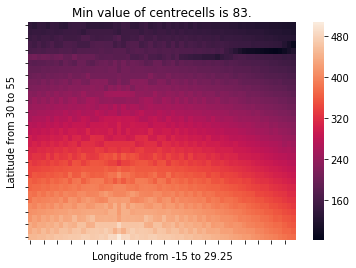

In [92]:
ax = sns.heatmap(np.array(nbrcells).reshape(len(data_dict.keys()), len(lons)))
ax.invert_yaxis()
ax.set_title("Min value of centrecells is 83.")
ax.set_xticklabels([''])
ax.set_yticklabels([''])
ax.set_xlabel('Longitude from -15 to 29.25')
ax.set_ylabel('Latitude from 30 to 55')
plt.savefig(save_dir + "number_of_centre_cell_resampling.png")

In [94]:
idx_lat = np.where(lat_array > 30)

/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [95]:
idx_lon = np.where(lon_array > -15)

/home/hanna/anaconda3/envs/sciclouds/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [97]:
d_phi.reshape(-1)[idx_lat]  

IndexError: too many indices for array

In [ ]:
d_theta.reshape(-1)[idx_lat]  

In [ ]:
areas = []
lats = np.arange(30, 56, 0.75)
lons = np.arange(-15, 30, 0.75)

for la in lats:
    for lo in lons:
        area = compute_area_one_cell(lat = la, lon = lo, c_lat = lat_array.reshape(-1), 
                              c_lon = lon_array.reshape(-1), d_theta = d_theta_new2.reshape(-1), 
                              d_phi = d_phi_new2.reshape(-1), cloud_mask_array = cloud_mask.reshape(-1)  )
        areas.append(area)

In [15]:
#areas

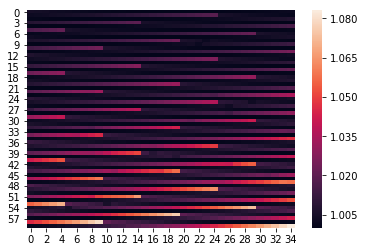

In [16]:
# reshape and make heatmap of aeras.
import seaborn as sns

ax = sns.heatmap((np.array(areas)).reshape(len(lons), len(lats)))
#ax.set_xticklabels(lons)
#ax.set_yticklabels(lats)

In [25]:
lons 

array([-15.  , -14.25, -13.5 , -12.75, -12.  , -11.25, -10.5 ,  -9.75,
        -9.  ,  -8.25,  -7.5 ,  -6.75,  -6.  ,  -5.25,  -4.5 ,  -3.75,
        -3.  ,  -2.25,  -1.5 ,  -0.75,   0.  ,   0.75,   1.5 ,   2.25,
         3.  ,   3.75,   4.5 ,   5.25,   6.  ,   6.75,   7.5 ,   8.25,
         9.  ,   9.75,  10.5 ,  11.25,  12.  ,  12.75,  13.5 ,  14.25,
        15.  ,  15.75,  16.5 ,  17.25,  18.  ,  18.75,  19.5 ,  20.25,
        21.  ,  21.75,  22.5 ,  23.25,  24.  ,  24.75,  25.5 ,  26.25,
        27.  ,  27.75,  28.5 ,  29.25])

In [31]:
xticks

array([-15.  , -12.25,  -9.5 ,  -6.75,  -4.  ,  -1.25,   1.5 ,   4.25,
         7.  ,   9.75,  12.5 ,  15.25,  18.  ,  20.75,  23.5 ,  26.25,
        29.  ])

In [32]:
np.arange()

TypeError: Required argument 'start' (pos 1) not found

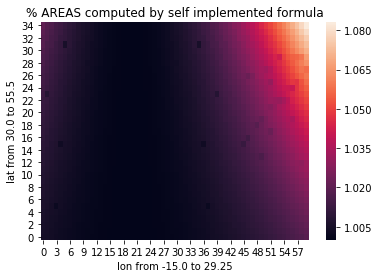

In [36]:
ax = sns.heatmap((np.array(areas)).reshape(len(lats), len(lons)))
ax.invert_yaxis()
ax.set_xlabel("lon from {} to {}".format(min(lons), max(lons)))
ax.set_ylabel("lat from {} to {}".format(min(lats), max(lats)))
#ax.yticklabels(visible = False);
#ax.set_xticklabels(lons);
ax.set_title("% AREAS computed by self implemented formula")
#plt.savefig('test_areas.png')